<center>
<header>

<h4 style="text-align:right">2023-01-25</h4>
<h2 style="text-align:center">Foundations of Deep Learning</h2>
<h1 style="background-color:DodgerBlue;">HOMEWORK 1</h1>
<h3>GIACOPELLI Nicolò, MICHEL Pauline
</h3>

</header>
</center>


In [1]:
!pip install patchify --quiet
!pip install wandb --quiet
!pip install torch --quiet
!pip install albumentations --quiet
!pip install pytorch_toolbelt --quiet
!pip install torchmetrics --quiet
!pip install segmentation-models-pytorch --quiet
!pip install import-ipynb --quiet

import os
import sys
import json 
from pprint import pprint
import numpy as np
import pandas as pd
from patchify import patchify, unpatchify
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from pytorch_toolbelt.losses.dice import DiceLoss
from pytorch_toolbelt.losses.focal import CrossEntropyFocalLoss
from torchmetrics.classification import MulticlassJaccardIndex
from torchmetrics import Dice
import datetime
import tarfile

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torch.optim.lr_scheduler as lr_scheduler
from tqdm.notebook import tqdm
from collections import defaultdict
from itertools import product
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torch.linalg import norm
from torchmetrics.classification import MulticlassConfusionMatrix
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights
import segmentation_models_pytorch as smp

from sklearn.model_selection import train_test_split
from numpy.random import RandomState
from torchsummary import summary

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import numpy as np
from PIL import Image
import cv2
import wandb

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report 
import seaborn as sns



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.9/178.9 KB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.6/157.6 KB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 KB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 KB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 39.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 17.6 MB/s et

In [2]:

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


### Import data ###

In [ ]:

!mkdir /content/drive/MyDrive/Hurricane_Harvey
!mkdir /content/drive/MyDrive/Hurricane_Harvey/rasters 
!mkdir /content/drive/MyDrive/Hurricane_Harvey/vectors

!mkdir /content/drive/MyDrive/Hurricane_Harvey/Model_parameters  # create directory to store model parameters

!gsutil -m cp -n -r gs://geoengine-dataset-houston-uav/rasters/raw /content/drive/MyDrive/Hurricane_Harvey/rasters/
!gsutil -m cp -n -r gs://geoengine-dataset-houston-uav/vectors/random-split-_2022_11_17-22_35_45/ /content/drive/MyDrive/Hurricane_Harvey/vectors/ 



### Macro variables ###

In [3]:

label_dict = {0: 'Unlabelled',
              1: 'Property Roof',
              2: 'Secondary Structure',
              3: 'Swimming Pool',
              4: 'Vehicle',
              5: 'Grass',
              6: 'Trees/Shrubs',
              7: 'Solar Panels',
              8: 'Chimney',
              9: 'Street Light',
              10: 'Window',
              11: 'Satellite Antenna',
              12: 'Garbage Bins',
              13: 'Trampoline',
              14: 'Road/Highway',
              15: 'Under Construction/In Progress Status',
              16: 'Power Lines & Cables',
              17: 'Bridge',
              18: 'Water Tank/Oil Tank',
              19: 'Parking Area - Commercial',
              20: 'Sports Complex/Arena',
              21: 'Industrial Site',
              22: 'Dense Vegetation/Forest',
              23: 'Water Body',
              24: 'Flooded',
              25: 'Boat',
              26: 'Parking Area'}


In [4]:
# Descriptive variables computed on the training + validation data for normalization purposes
# comparable to ImageNet, but we take those specific to the dataset


# IMAGENET stastics 
# mean_imagenet = [0.485, 0.456, 0.406]
# std_imagenet = [0.229, 0.224, 0.225]


# TRAINABLE images statistics (excluding Test Set)
mean = [0.43965176, 0.46535569, 0.39020824] 
std = [0.17914353, 0.16148314, 0.18918118]
stats = [mean, std]

denormalize = T.Compose([T.Normalize(mean = [0.]*3, std = 1/torch.tensor(np.array(stats[1])*255)), 
                          T.Normalize(mean = -torch.tensor(np.array(stats[0])*255), std = [ 1.]*3)])  

# for denormalization we go all the way from approx [-2, 2] float (after normalization) to [0, 255] int (we don't in the opposite normalization procedure since there is TensorV2)



In [5]:
# Definition of useful paths

root = "/content"

IMG_FOLDER = os.path.join(root, "drive/MyDrive/Hurricane_Harvey/rasters/raw")
# 374 images in tif

#INFO_FOLDER = 
INFO_FOLDER = os.path.join(root, "drive/MyDrive/Hurricane_Harvey/vectors/random-split-_2022_11_17-22_35_45")  
# 299 images -> 75 for Test Set

COCO_FOLDER = os.path.join(INFO_FOLDER, "COCO")
CSV_FOLDER = os.path.join(INFO_FOLDER, "CSV")
MASK_FOLDER = os.path.join(INFO_FOLDER, "Masks")

device = "cuda" if torch.cuda.is_available() else "device"


## Utilities ##

In [6]:
def path_image(name): 
  ''' utility function to return path of image'''
  return os.path.join(IMG_FOLDER, str(name) + ".tif")


def path_mask(name):
  ''' utility function to return path of mask'''
  return os.path.join(MASK_FOLDER, str(name) + ".png")


def timer(start_time=None, string=None):
    '''
    Function to compute the time
    start_time : starting time generated calling this function without arguments the first time
    string: visualization purposes (task description)
    '''
    if not start_time:
        start_time=datetime.datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.datetime.now()-start_time).total_seconds(),3600)
        tmin, tsec = divmod(temp_sec,60)
        pr = "for " + str(string) + " " if string else ""
        print("Execution time", pr, "is ", thour," h :", tmin,' m :', round(tsec,2), " s")


def write_flush(text, stream=sys.stdout):
    stream.write(text)
    stream.flush()
    return

def wandb_connect():
  ''' connection to WandB with personal API key '''
  wandb_api_key_label = "wandb_api_key"
  wandb_api_key = "bd92c5fdff527b9865af4be367366ca626f302e2" 

  wandb_conx = wandb.login(key = wandb_api_key)
  print(f"Connected to Wandb online interface : {wandb_conx}")


def update_history(history, loss, mean_iou, dice_score, type_):
  ''' function to clean train loop from redundant code
      history is defaultdict(list) to which we append all the metrics gathered in the trainign loop 
      type_ in "train" or "valid" to define the extension for the keys of the dictionary store'''
  assert type_ in ["tr", "val"]
  extens = "train" if type_=="tr" else "valid"
  history[extens + "_loss"].append(loss)
  history["mean_iou_" + extens].append(mean_iou)
  history["dice_score_" + extens].append(dice_score)
  return history


## Metrics ##

We use some metrics speficic to the segmentation problems. In particular, we use the Mean IOU, also called Jaccard Index, which points at the relative proportion of correctly predicted values over their total appearences (a sort of intersection over union). The metric is computed per class and then averaged.Also the Dice coefficient is used, which is a different variation of same concepts coming from the confusion matrix, peculiar to a classification problem. We implemented them but for RAM problems we decided to use the already available torchmetric versions

In [126]:
def mean_iou(preds, targets, device):
  ''' computes the mean iou index '''
  with torch.no_grad():
    metr = MulticlassJaccardIndex(num_classes=len(label_dict)).to(device) 
    res = metr(preds, targets).to(device)
    return (res.item())

def dice_coefficient(preds, targets, device):
  ''' computes the Dice coefficient '''
  with torch.no_grad():
    metr = Dice(num_classes=len(label_dict), average="macro").to(device) 
    res = metr(preds, targets).to(device)
    return (res.item())

def _report(masks, predictions):
  with torch.no_grad():
    rep = classification_report(masks, predictions, target_names=label_dict.values())
    return (rep)




In [ ]:
def compute_confusion_matrix(model, val_loader, size, normal, device):
  ''' '''
  assert normal in ["none", "true", "pred", "all"]  
  model = model.to(device)
  model.eval() 
  tot_masks, tot_preds = torch.Tensor([]).to(device), torch.Tensor([]).to(device)

  with torch.no_grad():
    for idx, (im, mask) in enumerate(val_loader):
      torch.cuda.empty_cache()
      im_batch = im.reshape(-1, 3, size[0], size[1]).to(device) 
      mask_batch = mask.reshape(-1, 1, size[0], size[1]).squeeze(1).to(device) 

      output = model.forward(im_batch.float())["aux"]
      predictions = torch.argmax(F.softmax(output.detach(), dim=1), dim=1).to(device)

      tot_masks = torch.cat((tot_masks, mask_batch.detach()))
      tot_preds = torch.cat((tot_preds, predictions.detach()))

  conf = MulticlassConfusionMatrix(num_classes = len(label_dict), normalize=normal).to(device)
  
  cm = conf(tot_preds.long(), tot_masks.long()).cpu().numpy()
  fig, ax = plt.subplots(1, 1, figsize=(11,11))
  sns.heatmap(cm, annot=True, fmt='.1f', ax=ax, cbar=False, xticklabels=label_dict.values(), yticklabels=label_dict.values())
  plt.show()
  return cm, tot_masks, tot_preds

## Early Stopping ##

We implemented Early Stopping as a measure to counteract overfitting. By keeping track of the evolution of the validation loss, it allows a predefined number of epochs to improve the best scores among the ones already attained.

In [9]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""

    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', save_every=5):
        """
        patience (int): How long to wait after last time validation loss improved.
        verbose (bool): If True, prints a message for each validation loss improvement. 
        delta (float): Minimum change in the monitored quantity to qualify as an improvement.
        path (str): Path for the checkpoint to be saved to.            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.save_every = 5

        if not os.path.exists(self.path):
          os.makedirs(self.path)

        
    def __call__(self, val_loss, model, epoch_number):
      ''' the value of the validation loss is passed at each iteration to the instance of the 
          EarlyStopping Class, which takes appropriate decisions also depending on the number
          of the current epoch'''
        score = -val_loss

        if self.best_score is None:
            self.best_score = score

        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'\nEarlyStopping counter: {self.counter} out of {self.patience}\n')
            if self.counter >= self.patience:
                self.early_stop = True
                torch.save(model.state_dict(), self.path + f"_e{epoch_number}.pt")
        else:
            self.best_score = score
            self.val_loss_min = val_loss
            self.counter = 0
            torch.save(model.state_dict(), self.path + f"_e{epoch_number}.pt")
            if self.verbose:
              print(f'Validation loss decreased ({self.val_loss_min:.5f} --> {val_loss:.5f})')

        if epoch_number % self.save_every == 0:
              torch.save(model.state_dict(), self.path + f"_e{epoch_number}.pt")


## Graphs ##

Collections of functions useful along the way to plot predictions or pairs of image/mask, also for sanity checks after long transformations

In [10]:

def graph_single(history, path_image):
  ''' function to plot loss, evolution of learning rate,
      evolution of Mean IOU and evolution of Dice score after
      the training (all the metrics are contained in the history
      dictionary)

      history: defaultidict(list) with the gathered metrics
      path_image: path to save the image'''

  c = ["red", "blue", "green"]
  lab = ["Train", "Validation"]
  y_label = [["Loss", "Learning rate"], ["Mean IOU", "Dice score"]]
  title_lst = [[x[0] + " evolution", x[1] + " evolution"] for x in y_label] 
  title_lst[0][1] = y_label[0][1] + " schedule"
  lab_type = ["train", "valid"]
  utils_keys = [["_loss", "learning_rates"], ["mean_iou_", "dice_score_"]]
  nb_epochs = len(history["train_loss"])

  epochs = range(1, nb_epochs+1, 5)
  fig, axs = plt.subplots(2, 2, figsize=(20, 17))

  for idx, ax in enumerate(axs):
    for id, a in enumerate(ax):
      for i, type_ in enumerate(lab_type):
        if not (idx==0 and id==1):
          key = type_ + utils_keys[idx][id] if ((idx==0) and (id==0)) else utils_keys[idx][id] + type_
          to_plot = [x.item() for x in history[key]] if type(history[key][1])==torch.Tensor else history[key]
          a.plot(list(range(1, nb_epochs+1)), to_plot, linewidth=1.4, color=c[i], label = lab[i])     
          a.legend()    
        else:
          key = utils_keys[idx][id]
          a.plot(list(range(1, nb_epochs+1)), history[key], linewidth=1.4, color=c[2])
        a.set_xlabel("Epochs", fontsize=17)
        tit = title_lst[idx][id]
        a.set_title(tit, fontsize=21) 
        y_lab = y_label[idx][id]
        a.set_ylabel(y_lab, rotation=90, fontsize=17)
        a.yaxis.set_label_coords(-0.06, 0.5)
        a.xaxis.set_label_coords(0.5, -0.05)
        a.set_xticks(epochs)
        a.set_xticklabels(epochs)
  
  f_path = "/content/drive/MyDrive/Hurricane_Harvey"
  plt.tight_layout()
  plt.savefig(os.path.join(f_path, path_image), bbox_inches='tight')
  plt.show()


In [11]:
def check_image_mask(loader, denormalize, final_size):
  ''' function that takes one instance from the loader of both image
      and associated mask, denormalize and reshapes the images to then plot them
      implemented for safety checks'''
  
  tot_im, tot_mask = next(iter(loader))
  if tot_im.shape[0]==1:
    tot_im, tot_mask = tot_im.view(-1, 3, final_size, final_size), tot_mask.view(-1, final_size, final_size)
  elif tot_im.shape[0]!=1: # more than one image/patch at each iteration
    idx = np.random.randint(tot_im.shape[0])
    tot_im, tot_mask = tot_im[idx], tot_mask[idx]
  idx = np.random.randint(tot_im.shape[1])
  im = denormalize(tot_im)[idx ].permute(1, 2, 0).numpy().astype(np.uint8)
  mask = tot_mask.squeeze()[idx].numpy()
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))
  ax1.imshow(im)
  ax2.imshow(mask)
  plt.show()


##Dataset##

In [12]:


def gen_dataframes(trainable_names, test_names, prop_split=0.33):
    ''' Return pandas dataframes to use for pytorch Dataset as indexes, for train, valid and test data
        trainable_names: list of all names (without extension) for wihch there is a corresponding mask
        test_names: list fo names (without extension) for which there is not a corresponding mask
        prop_split = proportion for training / validation data

        to be noted, we take validation names before creating patches to keep same proportion of the 2 types of images 
        in both train and validation proportons of images (3072x4592). The two types are not too different, but after the
        downsizing they could have compromised the balance between training and validation set '''
    store = []
    names_st = [trainable_names, test_names]
    for idx, names_list in enumerate(names_st):
      df = pd.DataFrame({"initial": np.arange(len(names_list)),
                         "name": names_list, 
                         "img": [path_image(name) for name in names_list]})
      if idx==0:  # train and eval split
        df["mask"] = df["name"].apply(lambda name: path_mask(name))

      # size incorporates whether image is 3000,4000 or the wider version, used below with stratify to have the same %
      # of the two types of images in both train and validation set (and still shuffle with DataLoader later) can also not be used (-> change)
      df["size"] = df["name"].apply(lambda name: 0 if Image.open(path_image(name)).size[0]==4592 else 1)  

      if idx==0: 
        df_train, df_eval = train_test_split(df, test_size=prop_split, 
                                           random_state=RandomState(42), 
                                           stratify=df["size"]) 
        df_train, df_eval = df_train.reset_index(drop=True), df_eval.reset_index(drop=True)
        store += [df_train, df_eval]
        continue
      store.append(df)
      
      return (store[0], store[1], store[2])


def get_random_crop(image, mask, crop_height, crop_width):
  ''' function to return a random crop of a given height and width, used
      to create the engineered images '''

    max_y = image.shape[0] - crop_height
    max_x = image.shape[1] - crop_width
    y = np.random.randint(0, max_y)
    x = np.random.randint(0, max_x)
    img_crop = image[y: y + crop_height, x: x + crop_width, :]
    mask_crop = mask[y: y + crop_height, x: x + crop_width]
    return img_crop, mask_crop



def rescale_images(full_img, final_size, kern):
  ''' function to rescale the images to a final size. A combination of upsizing
      and downsizing are used. In particular, Inter Linear interpolation is used
      to first resize the image to a square dimension, and then cv2 pyrDown is used
      to scale them by half (1/4 of the area) every time. PyrDown uses a chain
      of pyramidal structure-based sampling techniques that help to keep the image
      faithful'''
  resized_img = cv2.resize(full_img, (1800, 1800), interpolation=cv2.INTER_LINEAR)
  # pyrdown works well https://docs.opencv.org/3.4/d4/d1f/tutorial_pyramids.html
  resized_img = cv2.pyrDown(resized_img, dstsize=(900, 900))
  resized_img = cv2.resize(resized_img, (final_size, final_size), interpolation=cv2.INTER_AREA) 
  resized_img = cv2.filter2D(src = resized_img, ddepth=-1, kernel=kern)  # kernel for sharpness enhancement is utilized
  return resized_img


def rescale_masks(full_mask, final_size, kern):
  ''' function used to rescale masks: number of dimension different from images, and no need
      to take too much care about the quality of the images '''
  # nearest neighbor approximation for masks so that unique classes are preserved
  resized_mask = cv2.resize(full_mask, (final_size, final_size), interpolation=cv2.INTER_NEAREST)
  return resized_mask  



In [13]:

# Initializations of lists containing names that split the data in training, validation and test
# the names are sorted (in particular the test one) so that everything remains sorted in the dataframe
# and in the DataLoader as well

img_names_clean = [os.path.splitext(filename)[0] for filename in sorted(os.listdir(IMG_FOLDER))]   # sorted
mask_names_clean = [os.path.splitext(filename)[0] for filename in sorted(os.listdir(MASK_FOLDER))]

trainable_names = list(set(mask_names_clean))  # no duplicates but just to be sure
test_names = sorted(list(set(img_names_clean).difference(set(trainable_names))))  # sorted, so first element from torch dataset is the first in alphabetical order in the dataframe

train_df, valid_df, test_df = gen_dataframes(trainable_names, test_names, prop_split=0.33)

train_names, valid_names = train_df["name"].tolist(), valid_df["name"].tolist()


print(f"Number of masks: {len(mask_names_clean)}")
print(f"Number of images: {len(img_names_clean)}")

print(f"\nCheck length of train set: {train_df.shape[0]}")
print(f"Check length of validation set: {valid_df.shape[0]}\n")
print(f"Check length of test set: {test_df.shape[0]}\n")

train_df.head()



Number of masks: 299
Number of images: 374

Check length of train set: 200
Check length of validation set: 99

Check length of test set: 75



initial  name                                                img  \
0       50  7467  /content/drive/MyDrive/Hurricane_Harvey/raster...   
1      240  6546  /content/drive/MyDrive/Hurricane_Harvey/raster...   
2       63  9925  /content/drive/MyDrive/Hurricane_Harvey/raster...   
3       94  6459  /content/drive/MyDrive/Hurricane_Harvey/raster...   
4      144  6420  /content/drive/MyDrive/Hurricane_Harvey/raster...   

                                                mask  size  
0  /content/drive/MyDrive/Hurricane_Harvey/vector...     0  
1  /content/drive/MyDrive/Hurricane_Harvey/vector...     1  
2  /content/drive/MyDrive/Hurricane_Harvey/vector...     1  
3  /content/drive/MyDrive/Hurricane_Harvey/vector...     1  
4  /content/drive/MyDrive/Hurricane_Harvey/vector...     1

## Creation of additional engineered images ##

One initial approach was to engineer some new images from existing ones. At the time fo the implementation, the technique used was to first create $4$ patches out of the original images. The different sizes of $3000$x$4000$ and $3072$x$4592$ were then subdivided in 4 patches, of dimensions $1500$x$2000$ in the first case and $1536$x$2296$ in the second. The $4$ patches generated from an image were then rescaled to a squared dimensions ($1800$x$1800$) and then pyrDowned by half every time up to the desired shape (the one to feed the neural net with). To generate engineered images, a similar procedure was then implemented. Random crops of size $1800$x$1800$ were then generated, and a similar procedure of rescaling was followed with the addition of some noise-generating transformations (change in the brightness level, rotation $\cdots $ defined outside of this function. 

In [14]:

def gen_engineered_images(data_df, new_folder, n_generation, transforms, final_size=450):
  ''' function to generate engineered images of a given dimension from existing ones and save them in 
      the provided folder. The transformations are performed with Albumination to be sure that the images and masks
      follow the saem transformations and are therefore reliable. 
      data_df: dataset with info about images and mask paths
      new_folder: str path to save
      n_generation: int number of images to generate
      transforms: list of Albumentation transform
      final_size: int since squared dimensions were predisposed
      '''

  final = {"name": [], "img": [], "mask": []}
  len_available = data_df.shape[0]
  kern = np.array([[0, -1, 0],
                  [-1, 5, -1],
                  [0, -1, 0]])  # to sharpen image, https://www.askpython.com/python-modules/opencv-filter2d

  exists = os.path.exists(new_folder)
  if not exists:
   os.makedirs(new_folder)
   os.makedirs(os.path.join(new_folder, "raw"))
   os.makedirs(os.path.join(new_folder, "masks"))

  for id in range(n_generation):
    idx = np.random.randint(0, len_available)
    info = data_df.iloc[idx]

    full_img = np.array(Image.open(info["img"]))
    full_mask = np.array(Image.open(info["mask"]))
    name = info["name"]

    cropped_image, cropped_mask = get_random_crop(full_img, full_mask, 1500, 2000)
    cropped_image = rescale_images(cropped_image, final_size, kern)
    cropped_mask = rescale_masks(cropped_mask, final_size, kern)
      
    cv2.imwrite(os.path.join(new_folder, "raw", f"{name}_{id}" + ".tif"), cropped_image)
    cv2.imwrite(os.path.join(new_folder, "masks", f"{name}_{id}" + ".png"), cropped_mask)

    final["name"].append(f"{name}_{id}")
    final["img"].append(os.path.join(new_folder, "raw", f"{name}_{id}" + ".tif"))
    final["mask"].append(os.path.join(new_folder, "masks", f"{name}_{id}" + ".png"))
  
  print("\nDone!")

  print(f"\nShape of original image: {full_img.shape}")
  print(f"Shape of engineered image: {cropped_image.shape}")

  fig, axs = plt.subplots(2, 2, figsize=(16, 12))

  titles = [["Original", "Original"], ["Engineered", "Engineered"]]
  var = [[full_img, full_mask], [cropped_image, cropped_mask]]

  for idx, ax in enumerate(axs):
    for id, a in enumerate(ax):
      a.axis("off")
      a.imshow(var[idx][id])
      a.set_title(titles[idx][id], fontsize=16)

  final = pd.DataFrame(final)
  plt.show()
  return final




Done!

Shape of original image: (3000, 4000, 3)
Shape of engineered image: (450, 450, 3)


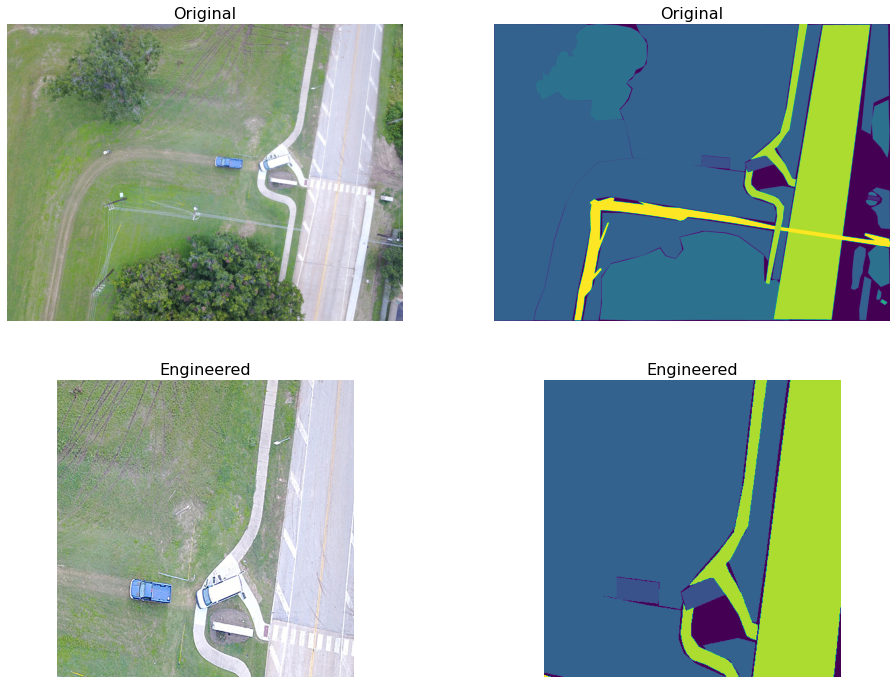

In [39]:
# generation of engineered images

random_transforms = A.Compose(
                                [
                                    A.RandomBrightnessContrast(brightness_limit=0.25, contrast_limit=0.35, p=0.3),
                                    A.HueSaturationValue(20, 20, 20, p=0.4),
                                    A.RGBShift(25, 25, 25, p=0.5),
                                    A.RandomRotate90(p=0.4),
                                    A.VerticalFlip(p=0.4)
                                ]
                            )


eng_path = "/content/drive/MyDrive/Hurricane_Harvey/new_images"  # inside two additional folders "raw" and "masks" are created

final_siz = 450
n_gen = 1200    #  number of additional patches to be engineered, (training set is 1200, since dividing each patch in 4)

eng_df = gen_engineered_images(train_df, eng_path, n_generation=n_gen, transforms=random_transforms, final_size=final_siz)  



They seemed reliable and good augmentations that could improve the generalization ability of our model when facing unseen scenarios. Their help was indeed present but up to a certain point

### Load data ###

According to this first approach, our DataSet was taking paths from both real and engineered images. In particular, only for the training set the Loader and the Dataset were taking $2$ real patches and $2$ engineered patches at each iteration, out of the $4$ squared patches that were generated from an initial image. We could have had therefore variability thanks to the engineered images, but proposing more frequently to the model actual images with more resemblance to the validation set. Albumination is used instead of torch to pass mask together with images and be sure they follow the same transformations in the presence of random transforms.  Normalization and Tensorization are implemented with the list of transforms.

In [ ]:

class RasterDataset(Dataset):
  def __init__(self, data_df, eng_df, transform, test=False, mask=True, final_size=450):
    
    ''' data_df: pandas dataframe storing images and mask paths of real images
        eng_df: pandas dataframe storing images and mask paths of engineered images
        transform: Albumination list of transforms (torch normalization by default)
        test: bool, whether to pass also half of engineered patches in one iteration or only real images
              ==True for validation and test set
        mask: bool, True for Test Set (absence of masks)
        final_size: int, only squared shapes were implemented at the beginning '''
    
    self.data = data_df
    self.add_df = eng_df
    self.transform = transform
    self.final_size = final_size
    self.test=test
    self.mask = mask
    self.kern = np.array([[0, -1, 0],
                          [-1, 5, -1],
                          [0, -1, 0]])  # to sharpen image, https://www.askpython.com/python-modules/opencv-filter2d

  def create_patches(self, img, mask, height, width):
    ''' function to create 4 equivalent rectangular patches from an original image. 
        Pillow crop is used to precisely determine the extremes of each patches.
        Half and width of patches are half the original ones
        height, width: int, height and width of crop
        img, mask: Pillow images'''
    
    height_patch, width_patch = int(height/2), int(width/2)
    store_mask_patch = []
    store_img_patch = []
    for store, entire in zip([store_img_patch, store_mask_patch], [img, mask]):
      store.append(entire.crop((0, 0, width_patch, height_patch)))
      store.append(entire.crop((width_patch, 0, width, height_patch)))
      store.append(entire.crop((0, height_patch, width_patch, height)))
      store.append(entire.crop((width_patch, height_patch, width, height)))
    return store_img_patch, store_mask_patch

  def create_patches_test(self, img, height, width):
    ''' same as before but for test set with the absence of masks '''
    height_patch, width_patch = int(height/2), int(width/2)
    store_img_patch = []
    for store, entire in zip([store_img_patch], [img]):
      store.append(entire.crop((0, 0, width_patch, height_patch)))
      store.append(entire.crop((width_patch, 0, width, height_patch)))
      store.append(entire.crop((0, height_patch, width_patch, height)))
      store.append(entire.crop((width_patch, height_patch, width, height)))
    return store_img_patch

  def __len__(self):
    return self.data.shape[0]

  def __getitem__(self, index):
    info = self.data.iloc[index]
    full_img = Image.open(info["img"])

    if self.mask:
      full_mask = Image.open(info["mask"])
    assert full_img.size[0] in [4000, 4592], "unknown size"  # pillow sizes are inverted
    width, height = full_img.size

    # Big patches to then be resized
    if self.mask:
      store_img_patch, store_mask_patch = self.create_patches(full_img, full_mask, height, width)
    else:
      store_img_patch = self.create_patches_test(full_img, height, width) 

    # 2 out of 4 patches are substituted with engineered images processed before
    if not self.test:
      id_sub1, id_sub2 = np.random.randint(0, len(store_img_patch), size=2)  
      id_chos1, id_chos2 = np.random.randint(0, self.add_df.shape[0], size=2)
      im_eng1, im_eng2 = Image.open(self.add_df.iloc[id_chos1]["img"]), Image.open(self.add_df.iloc[id_chos2]["img"])
      mask_eng1, mask_eng2 = Image.open(self.add_df.iloc[id_chos1]["mask"]), Image.open(self.add_df.iloc[id_chos2]["mask"])
      store_img_patch[id_sub1] = im_eng1
      store_mask_patch[id_sub1] = mask_eng1
      store_img_patch[id_sub2] = im_eng2
      store_mask_patch[id_sub2] = mask_eng2

    store_img_patch = [rescale_images(np.asarray(im), self.final_size, self.kern) for im in store_img_patch]
    if self.mask:
      store_mask_patch = [rescale_masks(np.asarray(mask), self.final_size, self.kern) for mask in store_mask_patch]
    
    if self.mask:
      # Albumination
      list_transf = [self.transform(image=np.asarray(im), mask=np.asarray(mask)) for im, mask in zip(store_img_patch, store_mask_patch)]             # need arrays, output arrays
      img_patch_transf = torch.stack([transf["image"] for transf in list_transf])  # float32
      mask_patch_transf = torch.stack([transf["mask"] for transf in list_transf])  # uint8
      return img_patch_transf, mask_patch_transf  # float32 and unint8 returned
    else:
      transf = T.Compose([T.ToTensor(), T.Normalize(*stats)])
      list_transf = [transf(im) for im in store_img_patch]
      img_patch_transf = torch.stack(list_transf)[None, :, :, :] # float32
      return img_patch_transf


    

Transformations, useful for generalization, are used with cautious not to cause too much distortion. Changes in gue, brightness, hue and saturation are performed. Normalization and Tensorization are the only transforms for validation and test data.

In [ ]:

train_transform = A.Compose(
                              [
                                  A.RandomBrightnessContrast(brightness_limit=0.25, contrast_limit=0.25, p=0.4),
                                  A.HueSaturationValue(20, 20, 20, p=0.4),
                                  A.Normalize(*stats),
                                  ToTensorV2(),
                              ]
                            )

val_transform = A.Compose(
                            [
                                A.Normalize(*stats),
                                ToTensorV2()
                            ]
                         )  


train_dataset = RasterDataset(train_df, eng_df, transform=train_transform, test=False) 
valid_dataset = RasterDataset(valid_df, eng_df, transform=val_transform, test=True)  # tensorization and normalization already applied
test_dataset = RasterDataset(test_df, eng_df, transform=val_transform, test=True, mask=False) 

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, pin_memory=True) 
val_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, pin_memory=True) 



In [ ]:
for im, mask in train_loader:
  print(f"\nTR: Image size: {im.shape}, Mask size: {mask.shape}")
  break

for im, mask in val_loader:
  print(f"\nVAL: Image size: {im.shape}, Mask size: {mask.shape}")
  break


TR: Image size: torch.Size([1, 4, 3, 450, 450]), Mask size: torch.Size([1, 4, 450, 450])

VAL: Image size: torch.Size([1, 4, 3, 450, 450]), Mask size: torch.Size([1, 4, 450, 450])


### Sanity Checks ###

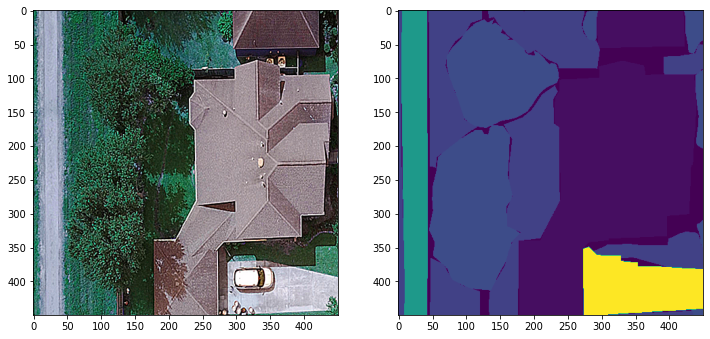

In [ ]:
# Checks, shape and visuals

# Images and Patches (with transform)

check_image_mask(train_loader, denormalize, final_siz)



# Model 1 - Deep LabV3 with default weights for ResNet50 encoder #

This first model was relying on the architecture described above, based on the creation of $4$ patches and resizing to a square size ($520$ was used). However, even though the way we constructed the setting could have allow the model to be more precise on the micro, while maybe losing a bit of context, and the prediction procedure to patch everything back together was correctly implementing, the setup proved to be less beneficial than less complicated ones. This model achieved a variable score between $10$ and $20$ on the platform. The structure is the one of an encoder-decoder scheme that has been frequently used for this Kaggle competition. The encoder in this case is a ResNet50 with pretrained weights, the model comes from torchvision. The last layer had to be re-defined for some problems in the API that did not allow for a n_classes definition (n. of channel outputs of final convolutional layer)

In [ ]:
n_classes = len(label_dict)  # 27 (also unlabelled)


weights = DeepLabV3_ResNet50_Weights.DEFAULT
model = deeplabv3_resnet50(weights=weights)  # num_classes = n_classes

model.aux_classifier[4] = nn.Conv2d(256, n_classes, kernel_size=(1, 1), stride=(1, 1))

model


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

## Hypeparameters ##

### Learning rate, momentum and optimizer ### 

We often tried to use different learning rates for encoder and decoder, with the idea of allowing the decoder and the final fully connected layer if present to update more than the backbone, which provides useful features constructed from havign seen billions of images. This generally worked. As a learning rate scheduler a Reduce on Plateau is implemented, which scales the learning rate proportionally when the validation loss does not improve for more than a predetermined number of epochs (here $6$).

In [ ]:
# optimizer


lr_ = 0.008
weight_dec = 1e-4
moment = 0.85

optimizer = torch.optim.AdamW([{"params": model.backbone.parameters(), "lr": 0.1*lr_}, 
                               {"params": model.classifier.parameters(), "lr": lr_},
                               {"params": model.aux_classifier.parameters()}], lr=lr_, betas=(moment, 0.999), weight_decay = weight_dec)


patience = 6
schedul_params = {"mode": 'min', "factor": 0.3, "patience": patience, "threshold": 1e-4}
sched = lr_scheduler.ReduceLROnPlateau(optimizer, **schedul_params)




## Loss Function ##

The Multiclass CrossEntropy loss is generally used. We tried also a combination of Focal loss and Dice loss, but proved not to work too well

In [ ]:


device = "cuda" if torch.cuda.is_available() else "cpu"

#weights = torch.tensor([1/n_classes]*n_classes).to(device)    # Tensor of size C
criterion = nn.CrossEntropyLoss()   #weight=weights


## Wandb logging and number of epochs ##

In [ ]:
# Wandb connection passing all parameters and device

wandb_connect()
wandb_project_name = "Kaggle_competition"


name_run = "deeplab"   # !!!!!! change name
name_model = "model_" + name_run

epochs = 100   # Early Stopping implemented

net = {"epochs": epochs,
        "opt": type(optimizer),
        "learning rate" : lr_,
        "momentum": moment,
        "weight decay": weight_dec,
        "scheduler": type(sched), 
        "scheduler_param": schedul_params,
        "mode": type(model),
        "criterion": type(criterion)
       }  


run = wandb.init(project=wandb_project_name, reinit=True, name=f"{name_run}", config=net) 


# create directory to save model's parameters

root = "/content/drive/MyDrive/Hurricane_Harvey/Model_parameters"

tot_path = os.path.join(root, str(name_model))


# Early Stopping

early_stopping = EarlyStopping(patience=12, verbose=False, delta=0, path=tot_path, save_every=5)  # Early Stopping




wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Connected to Wandb online interface : True


### Sanity Check ###

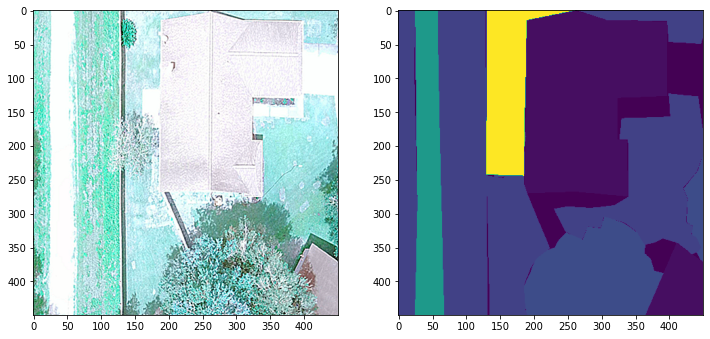

In [ ]:

check_image_mask(train_loader, denormalize, final_siz)


### Training loop ###

In [ ]:


def train_model(model, epochs, train_loader, val_loader, optimizer, criterion, sched, early_stopping, final_size, device):
  ''' function to implement the training loop, the parameters are all instances of optimizers, criterion, schedler and 
      early stopping as seen before. For each epoch one pass is made through the validation set to keep track of the metrics
      and update the early stopping and scheduler methods '''
      
  history = defaultdict(list)
  model = model.to(device)

  for epoch in tqdm(range(1, epochs+1)):  # tracking time only for epochs
    # Stores and Metrics
    train_store = []
    wandb.log({"epochs": epoch})

    dice_score_tr = torch.zeros((1)).to(device)
    mean_iou_tr = torch.zeros((1)).to(device)

     ## TRAINING
    model.train()
    for idx, (im, mask) in enumerate(train_loader):
      torch.cuda.empty_cache()
      im_batch = im.view(-1, 3, final_size, final_size).to(device)                           
      mask_batch = mask.view(-1, final_size, final_size).long().to(device)

      optimizer.zero_grad()
      output = model(im_batch.float())["aux"].to(device)  # (real_batch_size, 27, final_size, final_size)

      loss = criterion(output, mask_batch)
      loss.backward()
      optimizer.step()
      train_store.append(loss.item())

      predictions = torch.argmax(F.softmax(output.detach(), dim=1), dim=1).to(device)
      dice_score_tr += dice_coefficient(predictions, mask_batch, device)
      mean_iou_tr += mean_iou(predictions, mask_batch, device)
      
      wandb.log({"train_loss_batch": loss.item()}) # log the training loss at each batch 

      # Scheduler based on batches
      if isinstance(sched, lr_scheduler.OneCycleLR):
        history["learning_rates"].append(optimizer.param_groups[0]["lr"])
        sched.step()

    train_loss_mean = np.mean(train_store)
    mean_iou_tr = mean_iou_tr/len(train_loader)
    dice_score_tr = dice_score_tr/len(train_loader)
    history = update_history(history, train_loss_mean, 
                              mean_iou_tr.item(), dice_score_tr.item(), type_="tr")

    wandb.log({"train_loss": train_loss_mean, "mean_iou_tr": mean_iou_tr, "dice_score_train": dice_score_tr})

    ## VALIDATION
    model.eval() 

    val_store = []
    dice_score_val = torch.zeros((1)).to(device)
    mean_iou_val = torch.zeros((1)).to(device)

    with torch.no_grad():
      for idx, (im, mask) in enumerate(val_loader):
        torch.cuda.empty_cache()
        im_batch = im.view(-1, 3, final_size, final_size).to(device)                 
        mask_batch = mask.view(-1, final_size, final_size).long().to(device)   
      
        output = model(im_batch.float())["aux"].to(device) # (real_batch_size, 27, final_size, final_size)
        
        loss = criterion(output, mask_batch)
        val_store.append(loss.item())

        predictions = torch.argmax(F.softmax(output.detach(), dim=1), dim=1).to(device)
        dice_score_val += dice_coefficient(predictions, mask_batch, device)
        mean_iou_val += mean_iou(predictions, mask_batch, device)

    val_loss_mean = np.mean(val_store)
    mean_iou_val = mean_iou_val/len(val_loader)  # vector
    dice_score_val = dice_score_val/len(val_loader)
    history = update_history(history, val_loss_mean, 
                           mean_iou_val.item(), dice_score_val.item(), type_="val")
  
    # Scheduler based on epochs
    if isinstance(sched, lr_scheduler.ReduceLROnPlateau):
      history["learning_rates"].append(optimizer.param_groups[0]["lr"])
      sched.step(val_loss_mean)
  
    # Log to Wandb
    wandb.log({"valid_loss": val_loss_mean, "mean_iou_val": mean_iou_val, "dice_score_valid": dice_score_val})

    print(
            "Epoch [{}/{}]..".format(epoch, epochs),
            "Train loss: {:.4f}..".format(train_loss_mean),
            "Validation loss: {:.4f}..".format(val_loss_mean),
            "Mean_iou train: {:.4f}..".format(mean_iou_tr.item()),
            "Mean_iou valid: {:.4f}..".format(mean_iou_val.item()),
            "Dice_score train: {:.4f}..".format(dice_score_tr.item()),
            "Dice_score valid: {:.4f}..".format(dice_score_val.item())
          )

    # early_stopping needs the validation loss to check if it has decresed, 
    # and if it has, it will make a checkpoint of the current model
    early_stopping(val_loss_mean, model, epoch)

    if early_stopping.early_stop:
        print("Early stopping")
        break

  return history



In [ ]:


history = train_model(model, epochs, train_loader, val_loader, optimizer, criterion, sched, early_stopping, final_siz, device)

# close wandb session
run.finish()


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/100].. Train loss: 1.5386.. Validation loss: 1.3861.. Mean_iou train: 0.0763.. Mean_iou valid: 0.0741.. Dice_score train: 0.2145.. Dice_score valid: 0.2174..
Epoch [2/100].. Train loss: 1.2959.. Validation loss: 1.0910.. Mean_iou train: 0.0999.. Mean_iou valid: 0.0980.. Dice_score train: 0.2598.. Dice_score valid: 0.2661..
Epoch [3/100].. Train loss: 1.1549.. Validation loss: 1.1030.. Mean_iou train: 0.1142.. Mean_iou valid: 0.0980.. Dice_score train: 0.2867.. Dice_score valid: 0.2667..

EarlyStopping counter: 1 out of 12

Epoch [4/100].. Train loss: 1.0728.. Validation loss: 1.0449.. Mean_iou train: 0.1246.. Mean_iou valid: 0.1007.. Dice_score train: 0.2933.. Dice_score valid: 0.2650..
Epoch [5/100].. Train loss: 0.9893.. Validation loss: 1.1511.. Mean_iou train: 0.1303.. Mean_iou valid: 0.1025.. Dice_score train: 0.3047.. Dice_score valid: 0.2662..

EarlyStopping counter: 1 out of 12

Epoch [6/100].. Train loss: 1.0054.. Validation loss: 1.0851.. Mean_iou train: 0.1352.. Mea

### Reload model ###

In [127]:
# Re-load model

root = "drive/MyDrive/Hurricane_Harvey"

weights = DeepLabV3_ResNet50_Weights.DEFAULT
model = deeplabv3_resnet50(weights=weights)  # num_classes = n_classes

model.aux_classifier[4] = nn.Conv2d(256, n_classes, kernel_size=(1, 1), stride=(1, 1))

timestamp_path = 'Model_parameters/model_deeplab_e22.pt'

model.load_state_dict(torch.load(os.path.join(root, timestamp_path)))  #map_location=torch.device("cpu")


Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth


  0%|          | 0.00/161M [00:00<?, ?B/s]

<All keys matched successfully>

## Confusion Matrix ##

In [130]:
def compute_confusion_matrix(model, val_loader, size, normal, device):
  ''' function to compute and display the confusion matrix. The best checkpoint of the model
      is pre-loaded and the predictions are computed ex-novo'''
  assert normal in ["none", "true", "pred", "all"]  # available values for normalization parameter (% instead of absolute values)
  model = model.to(device)
  model.eval() 
  tot_masks, tot_preds = torch.Tensor([]).to(device), torch.Tensor([]).to(device)

  with torch.no_grad():
    for idx, (im, mask) in enumerate(val_loader):
      torch.cuda.empty_cache()
      im_batch = im.reshape(-1, 3, size[0], size[1]).to(device) 
      mask_batch = mask.reshape(-1, 1, size[0], size[1]).squeeze(1).to(device) 

      output = model.forward(im_batch.float())["aux"] # (real_batch_size, 27, 512, 512)
      predictions = torch.argmax(F.softmax(output.detach(), dim=1), dim=1).to(device)

      tot_masks = torch.cat((tot_masks, mask_batch.detach()))
      tot_preds = torch.cat((tot_preds, predictions.detach()))

  conf = MulticlassConfusionMatrix(num_classes = len(label_dict), normalize=normal).to(device)
  
  cm = conf(tot_preds.long(), tot_masks.long()).cpu().numpy()
  fig, ax = plt.subplots(1, 1, figsize=(11,11))
  sns.heatmap(cm, annot=True, fmt='.1f', ax=ax, cbar=False, xticklabels=label_dict.values(), yticklabels=label_dict.values())
  plt.show()
  return cm, tot_masks, tot_preds

/usr/local/lib/python3.8/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: 54 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


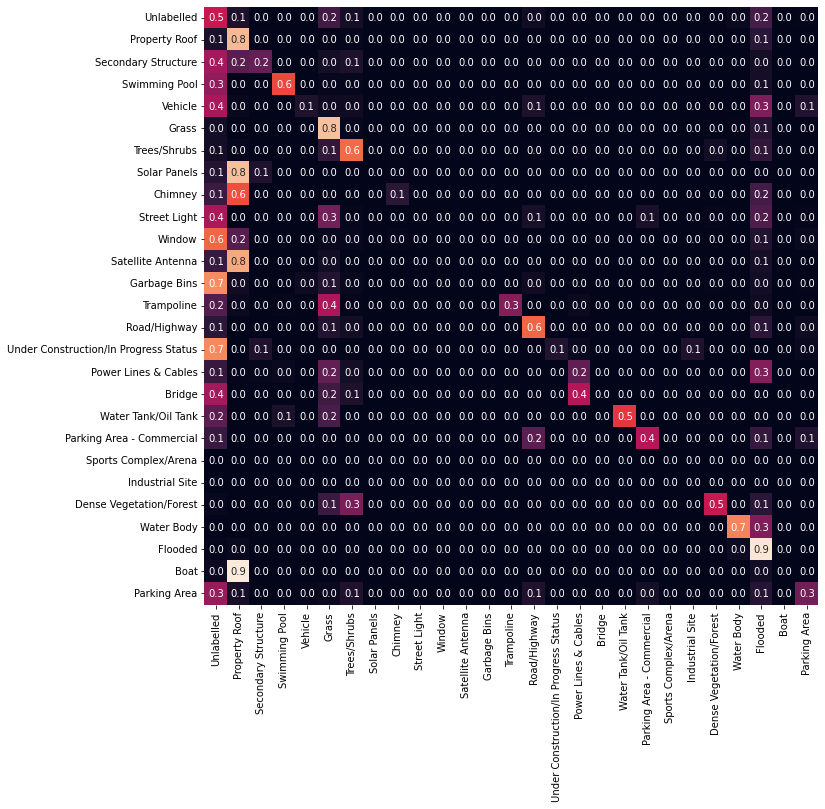

In [131]:

cm, masks, preds = compute_confusion_matrix(model, val_loader, final_siz, "true", device)

# real value is the row, predicted is the column


The confusion matrix seemed promising, but the model did not perform very well, probably for the preprocessing step which we decided to change (after the second model, which is LinkNet). As common, the unlabelled pixels are more often misunderstood for labelled ones (in particular "Under construction"). We tried to put more weights on this unlabelled features in the CrossEntropy computation, but it did not prove to work too well. The idea was to make the model able to distinguish more between pixels to be labelled and those not to. We attributed the results of this experiment to also possible noise made by human annotations.

## Predictions ##

As a note, we often found ourselves with the need to use multiple notebooks or share some among us. This implies that not all output are present (for lack of time), but we thought about inserting the procedure followed nonetheless.

In [132]:

def predict(model, test_df, test_dataset, device, dir_path):
  ''' function to compute the predictions, given a model checkpoint loaded in advance.
      The images in the test dataframe are read one by one, opened and predicted '''

  if not os.path.exists(dir_path):
    os.makedirs(dir_path)

  model.eval()
  model = model.to(device)
  with torch.no_grad():
    for idx in range(test_df.shape[0]):
      info = test_df.iloc[idx]
      name, path_img, size = info["name"], info["img"], info["size"]
      final_dim = (3000, 4000) if size==1 else (3072, 4592)   
      final_prediction = np.zeros(final_dim)

      img = test_dataset[idx]  
      img = img.view(-1, 3, test_dataset.final_size, test_dataset.final_size)  

      height_patch, width_patch = int(final_dim[0]/2), int(final_dim[1]/2)

      input = img.to(device)
      predictions_logits = model(input.float())["aux"].detach().cpu()
      predictions = torch.argmax(predictions_logits, dim=1).detach().numpy()  

      list_pred = []
      for idx in range(predictions.shape[0]): 
        # When setting the size to cv2.resize(), etc., it needs to be (width, height)
        resized_patch = cv2.resize(predictions[idx].astype(np.uint8), dsize=(width_patch, height_patch), interpolation=cv2.INTER_AREA)   # LINEAR, 
        list_pred.append(resized_patch.astype(np.uint8))

      final_prediction[:height_patch, :width_patch] = list_pred[0]
      final_prediction[:height_patch, width_patch:final_dim[1]] = list_pred[1]
      final_prediction[height_patch:final_dim[0], :width_patch] =  list_pred[2]
      final_prediction[height_patch:final_dim[0], width_patch:final_dim[1]] = list_pred[3]
      final_prediction = final_prediction.astype(np.uint8)

      print(f"Number of unique final labels {len(np.unique(final_prediction)), final_prediction.dtype}")

      im = Image.fromarray(final_prediction, "L")
      im.save(os.path.join(dir_path, f"{name}.png"), "PNG")
      

In [133]:
root = "drive/MyDrive/Hurricane_Harvey"

weights = DeepLabV3_ResNet50_Weights.DEFAULT
model = deeplabv3_resnet50(weights=weights) 

model.aux_classifier[4] = nn.Conv2d(256, n_classes, kernel_size=(1, 1), stride=(1, 1))

timestamp_path = 'Model_parameters/model_deeplab_e22.pt'

model.load_state_dict(torch.load(os.path.join(root, timestamp_path)))  #map_location=torch.device("cpu")

<All keys matched successfully>

In [ ]:
model.eval()


pred_path = "drive/MyDrive/Hurricane_Harvey/Predictions_deeplab"

if not os.path.exists(pred_path):
  os.makedirs(pred_path)

predict(model, test_df, test_dataset, device, dir_path=pred_path)

name_tar = "submission_deeplab"

tar = tarfile.open(f"drive/MyDrive/Hurricane_Harvey/{name_tar}.tar", "w")

for root, dir, files in os.walk(pred_path):
    for file in files:
        fullpath = os.path.join(root, file)
        tar.add(fullpath, arcname=file)

tar.close()



In [137]:

def plot_mask_and_prediction(model, df, dataset):
  model = model.to(device)
  model.eval()
  with torch.no_grad():
    idx = np.random.randint(0, df.shape[0])
    try:
      img_name, img_path, mask_path, img_size = df.iloc[idx][["name", "img", "mask", "size"]]
    except:
      print("Insert either train or validation dataset")

    final_dim = (3000, 4000) if img_size==1 else (3072, 4592)

    real_mask = np.asarray(Image.open(mask_path))
    real_img = np.asarray(Image.open(img_path)) 

    print(f"\nUnique labels in original: {np.unique(real_mask)}")

    img, mask = dataset[idx]  
    img = img.view(-1, 3, dataset.final_size[0], dataset.final_size[1]) 
    mask = mask.view(-1, dataset.final_size[0], dataset.final_size[1])  
    input = img.to(device)
    predictions_logits = model.forward(input.float())["aux"].detach().cpu()
    predictions = torch.argmax(predictions_logits, dim=1).detach().squeeze().numpy().astype(np.uint8) 

    final_prediction = cv2.resize(predictions, dsize=final_dim[::-1], interpolation=cv2.INTER_NEAREST)

    print(f"Unique labels in prediction: {np.unique(final_prediction)}\n")

    titles = ["Real img", "Real mask", "Predicted mask"]
    data = [real_img, real_mask, final_prediction]

    fig, axs = plt.subplots(1, 3, figsize=(22, 18))
    for idx, ax in enumerate(axs):
      ax.imshow(data[idx])
      ax.set_title(titles[idx], fontsize=18)
      ax.axis('off')    
    plt.show()



Unique labels in original: [ 0  2  5  6  9 14 24]
Unique labels in prediction: [ 0  2  5  6 14 16 19 23 24 26]



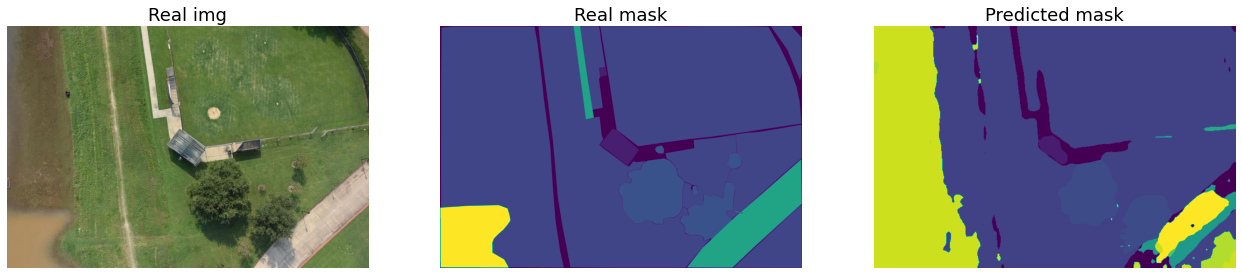

In [138]:

plot_mask_and_prediction(model, valid_df, valid_dataset)   # we do it on the validation dataset



# Model 2 - LinkNet with MobileNet as encoder #

For the second model we followed the same procedure and setup, so that it was not very performant neither. The structure is composed by a MobileNet as an encoder (pretty light, not too may parameters) and a Linknet as a decoder, which has a functioning similar to Unet but with summation instead than concatenation. We provided this model as something that did not work (scores on the platform around $10\%$). Arguably, this was for a lack of complexity as could be seen below. The most performant models are below.

### Generation of engineered images ###


Done!

Shape of original image: (3072, 4592, 3)
Shape of engineered image: (480, 480, 3)


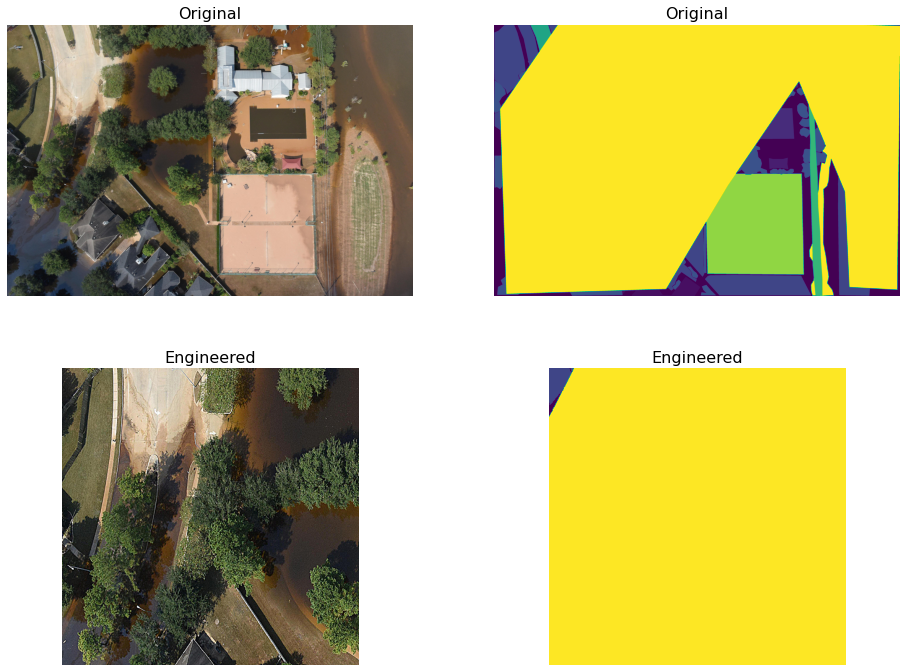

In [55]:

random_transforms = A.Compose(
                                [
                                    A.RandomBrightnessContrast(brightness_limit=0.25, contrast_limit=0.35, p=0.3),
                                    A.HueSaturationValue(20, 20, 20, p=0.4),
                                    A.RGBShift(25, 25, 25, p=0.5),
                                    A.RandomRotate90(p=0.4),
                                    A.VerticalFlip(p=0.4)
                                ]
                            )


eng_path = "/content/drive/MyDrive/Hurricane_Harvey/new_images2"  # inside two additional folders "raw" and "masks" are created

final_siz = 480
n_gen = 1200    #  number of additional patches to be engineered, (training set is 1200, since dividing each patch in 4)

eng_df = gen_engineered_images(train_df, eng_path, n_generation=n_gen, transforms=random_transforms, final_size=final_siz)  



### Datasets and DataLoaders ###

In [66]:

train_transform = A.Compose(
                              [   A.HorizontalFlip(p=0.5),
                                  A.VerticalFlip(p=0.5),
                                  A.RandomBrightnessContrast(brightness_limit=0.25, contrast_limit=0.25, p=0.4),
                                  A.Normalize(*stats),
                                  ToTensorV2()
                              ]
                            )

val_transform = A.Compose(
                            [
                                A.Normalize(*stats),
                                ToTensorV2()
                            ]
                         )  


train_dataset = RasterDataset(train_df, eng_df, transform=train_transform, final_size=final_siz, test=False) 

# in test and evaluation datast parameter True so that dataset returns only real images (rescaled) and not engineered ones (it does half and half in training)
valid_dataset = RasterDataset(valid_df, eng_df, transform=val_transform, final_size=final_siz, test=True) 
test_dataset = RasterDataset(test_df, eng_df, transform=val_transform, final_size=final_siz, test=True, mask=False)


train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, pin_memory=True) 
val_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, pin_memory=True) 


### Model ###

In [85]:
n_classes = len(label_dict)  

model = smp.Linknet(encoder_name='mobilenet_v2', encoder_depth=5, encoder_weights='imagenet', decoder_use_batchnorm=True, in_channels=3, classes=n_classes, activation=None)

model


Linknet(
  (encoder): MobileNetV2Encoder(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size

### Loss Function and hyperparameters ###

In [89]:
# optimizer


lr_ = 0.005
weight_dec = 5e-4
moment = 0.8

optimizer = torch.optim.Adam(model.parameters(), lr=lr_, betas=(moment, 0.999), weight_decay = weight_dec)


patience = 8
schedul_params = {"mode": 'min', "factor": 0.2, "patience": patience, "threshold": 1e-4}
sched = lr_scheduler.ReduceLROnPlateau(optimizer, **schedul_params)



In [90]:


device = "cuda" if torch.cuda.is_available() else "cpu"

criterion = nn.CrossEntropyLoss()   #weight=weights

#weights = torch.tensor([1/n_classes]*n_classes).to(device)    # Tensor of size C
#trainable_img_sizes["weight"] = np.where(trainable_img_sizes['size']==(3000, 4000, 3), 218/(299), 81/(299))  # frequency of the 2 different sizes in dataset of all trainable_images (excluding test)



### WandB connection ###

In [91]:
# Wandb connection passing all parameters and device
wandb_connect()
wandb_project_name = "Kaggle_competition"


name_run = "linknet"   # !!!!!! change name
name_model = "model_" + name_run

epochs = 100   # Early Stopping implemented

net = {"epochs": epochs,
        "opt": type(optimizer),
        "learning rate" : lr_,
        "momentum": moment,
        "weight decay": weight_dec,
        "scheduler": type(sched), 
        "scheduler_param": schedul_params,
        "mode": type(model),
        "criterion": type(criterion)
       }  


run = wandb.init(project=wandb_project_name, reinit=True, name=f"{name_run}", config=net) 


# create directory to save model's parameters
root = "/content/drive/MyDrive/Hurricane_Harvey/Model_parameters"

tot_path = os.path.join(root, str(name_model))



# Early Stopping

early_stopping = EarlyStopping(patience=15, verbose=False, delta=0, path=tot_path, save_every=5)  # Early Stopping




wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Connected to Wandb online interface : True



## Training loop ##

In [ ]:

def train_model(model, epochs, train_loader, val_loader, optimizer, criterion, sched, early_stopping, final_size, device):
  ''' similar to before (see above for the description of the function). had to be reimplemented for a different structure
      for the model output ) '''

  history = defaultdict(list)
  model = model.to(device)

  for epoch in tqdm(range(1, epochs+1)):  # tracking time only for epochs
    # Stores and Metrics
    train_store = []
    wandb.log({"epochs": epoch})

    dice_score_tr = torch.zeros((1)).to(device)
    mean_iou_tr = torch.zeros((1)).to(device)

     ## TRAINING
    model.train()
    for idx, (im, mask) in enumerate(train_loader):
      torch.cuda.empty_cache()
      im_batch = im.view(-1, 3, final_size, final_size).to(device)                           
      mask_batch = mask.view(-1, final_size, final_size).long().to(device)

      optimizer.zero_grad()
      output = model(im_batch.float()).to(device)  # (real_batch_size, 27, final_size, final_size)

      loss = criterion(output, mask_batch)
      loss.backward()
      optimizer.step()
      train_store.append(loss.item())

      predictions = torch.argmax(F.softmax(output.detach(), dim=1), dim=1).to(device)
      dice_score_tr += dice_coefficient(predictions, mask_batch, device)
      mean_iou_tr += mean_iou(predictions, mask_batch, device)
      
      wandb.log({"train_loss_batch": loss.item()}) # log the training loss at each batch 

      # Scheduler based on batches
      if isinstance(sched, lr_scheduler.OneCycleLR):
        history["learning_rates"].append(optimizer.param_groups[0]["lr"])
        sched.step()

    train_loss_mean = np.mean(train_store)
    mean_iou_tr = mean_iou_tr/len(train_loader)
    dice_score_tr = dice_score_tr/len(train_loader)
    history = update_history(history, train_loss_mean, 
                              mean_iou_tr.item(), dice_score_tr.item(), type_="tr")

    wandb.log({"train_loss": train_loss_mean, "mean_iou_tr": mean_iou_tr, "dice_score_train": dice_score_tr})

    ## VALIDATION
    model.eval() 

    val_store = []
    dice_score_val = torch.zeros((1)).to(device)
    mean_iou_val = torch.zeros((1)).to(device)

    with torch.no_grad():
      for idx, (im, mask) in enumerate(val_loader):
        torch.cuda.empty_cache()
        im_batch = im.view(-1, 3, final_size, final_size).to(device)                 
        mask_batch = mask.view(-1, final_size, final_size).long().to(device)   
      
        output = model(im_batch.float()).to(device) # (real_batch_size, 27, final_size, final_size)
        
        loss = criterion(output, mask_batch)
        val_store.append(loss.item())

        predictions = torch.argmax(F.softmax(output.detach(), dim=1), dim=1).to(device)
        dice_score_val += dice_coefficient(predictions, mask_batch, device)
        mean_iou_val += mean_iou(predictions, mask_batch, device)

    val_loss_mean = np.mean(val_store)
    mean_iou_val = mean_iou_val/len(val_loader)  # vector
    dice_score_val = dice_score_val/len(val_loader)
    history = update_history(history, val_loss_mean, 
                           mean_iou_val.item(), dice_score_val.item(), type_="val")
  
    # Scheduler based on epochs
    if isinstance(sched, lr_scheduler.ReduceLROnPlateau):
      history["learning_rates"].append(optimizer.param_groups[0]["lr"])
      sched.step(val_loss_mean)
  
    # Log to Wandb
    wandb.log({"valid_loss": val_loss_mean, "mean_iou_val": mean_iou_val, "dice_score_valid": dice_score_val})

    print(
            "Epoch [{}/{}]..".format(epoch, epochs),
            "Train loss: {:.4f}..".format(train_loss_mean),
            "Validation loss: {:.4f}..".format(val_loss_mean),
            "Mean_iou train: {:.4f}..".format(mean_iou_tr.item()),
            "Mean_iou valid: {:.4f}..".format(mean_iou_val.item()),
            "Dice_score train: {:.4f}..".format(dice_score_tr.item()),
            "Dice_score valid: {:.4f}..".format(dice_score_val.item())
          )

    # early_stopping needs the validation loss to check if it has decresed, 
    # and if it has, it will make a checkpoint of the current model
    early_stopping(val_loss_mean, model, epoch)

    if early_stopping.early_stop:
        print("Early stopping")
        break

  return history



In [93]:


history = train_model(model, epochs, train_loader, val_loader, optimizer, criterion, sched, early_stopping, final_siz, device)

# close wandb session
run.finish()


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/100].. Train loss: 1.8370.. Validation loss: 1.7828.. Mean_iou train: 0.0380.. Mean_iou valid: 0.0391.. Dice_score train: 0.1214.. Dice_score valid: 0.1420..
Epoch [2/100].. Train loss: 1.5998.. Validation loss: 1.7544.. Mean_iou train: 0.0496.. Mean_iou valid: 0.0421.. Dice_score train: 0.1591.. Dice_score valid: 0.1509..
Epoch [3/100].. Train loss: 1.5462.. Validation loss: 1.5723.. Mean_iou train: 0.0522.. Mean_iou valid: 0.0434.. Dice_score train: 0.1644.. Dice_score valid: 0.1536..
Epoch [4/100].. Train loss: 1.5046.. Validation loss: 1.5151.. Mean_iou train: 0.0538.. Mean_iou valid: 0.0504.. Dice_score train: 0.1678.. Dice_score valid: 0.1740..
Epoch [5/100].. Train loss: 1.4861.. Validation loss: 1.4529.. Mean_iou train: 0.0556.. Mean_iou valid: 0.0554.. Dice_score train: 0.1729.. Dice_score valid: 0.1943..
Epoch [6/100].. Train loss: 1.4696.. Validation loss: 1.5126.. Mean_iou train: 0.0573.. Mean_iou valid: 0.0537.. Dice_score train: 0.1794.. Dice_score valid: 0.1885.

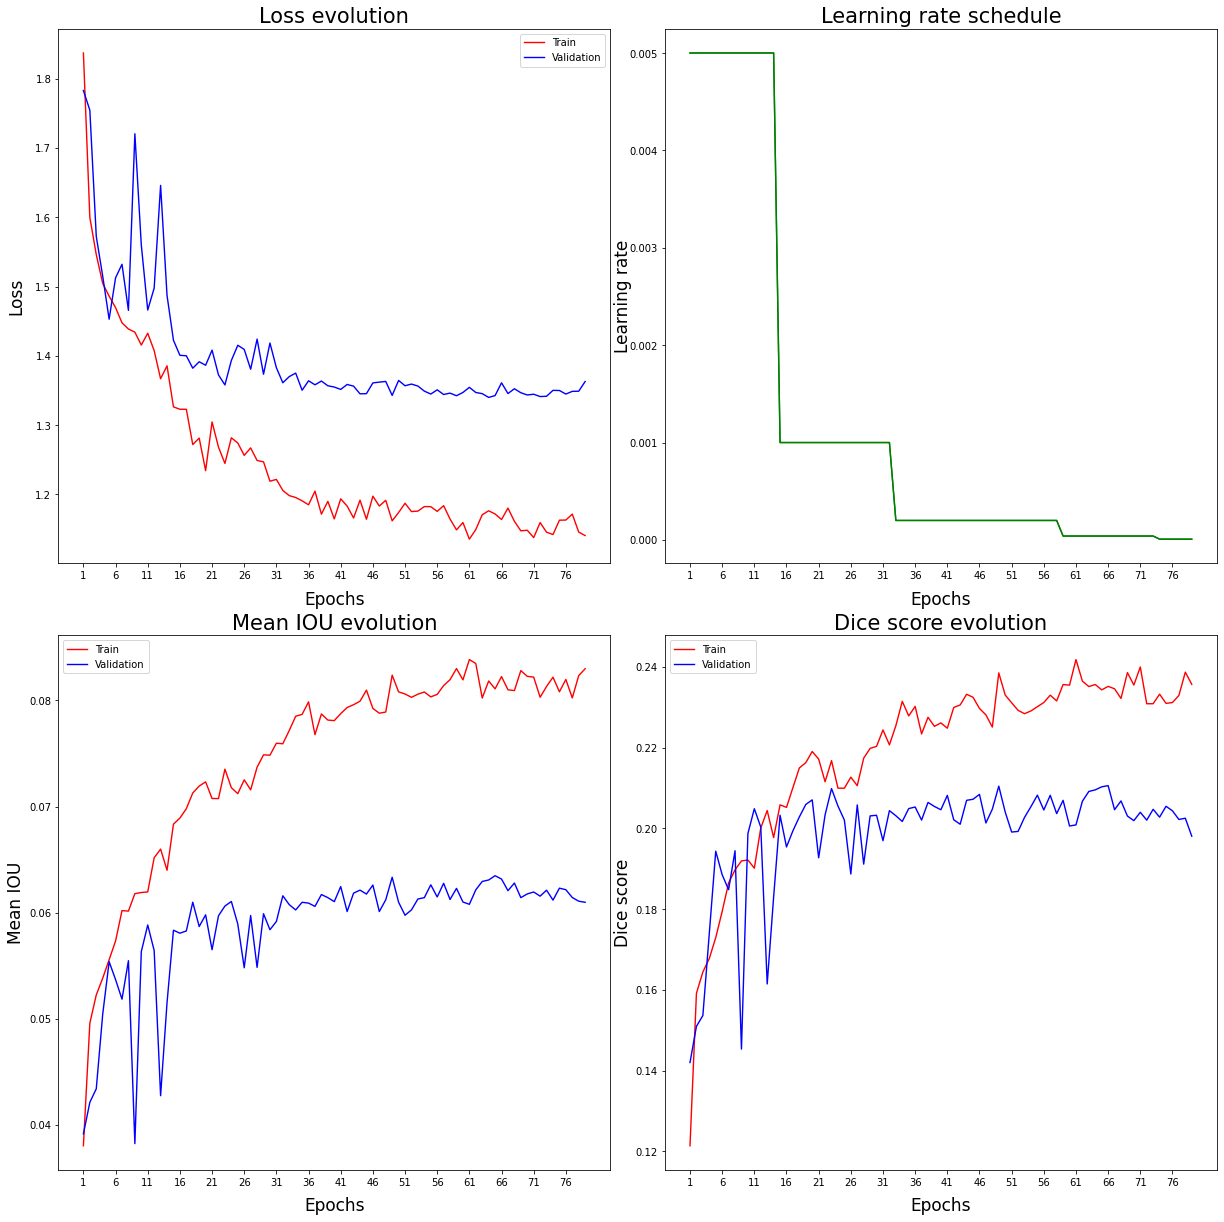

In [96]:

graph_single(history, "Linknet-AdamW-full")



In comparison to the other models, LinkNet proved to be the least performant as the Validation Loss and Metrics almost immediately flattened and never exhibit large improvements. This can arguably be for a lack of depth and complexity of the model, as MobileNet proved to be too light for this type of problem

## Reload model ##

In [140]:

root = "drive/MyDrive/Hurricane_Harvey"


model = smp.Linknet(encoder_name='mobilenet_v2', encoder_depth=5, encoder_weights='imagenet', decoder_use_batchnorm=True, in_channels=3, classes=n_classes, activation=None)


timestamp_path = 'Model_parameters/model_linknet_e30.pt'

model.load_state_dict(torch.load(os.path.join(root, timestamp_path))) 



<All keys matched successfully>

## Confusion Matrix ##

In [141]:
def compute_confusion_matrix(model, val_loader, size, normal, device):
  ''' again, had to be re-implemented for a difference in the API of the library
      for the comments see above'''
  assert normal in ["none", "true", "pred", "all"]
  model = model.to(device)
  model.eval() 
  tot_masks, tot_preds = torch.Tensor([]).to(device), torch.Tensor([]).to(device)

  with torch.no_grad():
    for idx, (im, mask) in enumerate(val_loader):
      torch.cuda.empty_cache()
      im_batch = im.reshape(-1, 3, size[0], size[1]).to(device) 
      mask_batch = mask.reshape(-1, 1, size[0], size[1]).squeeze(1).to(device) 

      output = model.forward(im_batch.float()) 
      predictions = torch.argmax(F.softmax(output.detach(), dim=1), dim=1).to(device)

      tot_masks = torch.cat((tot_masks, mask_batch.detach()))
      tot_preds = torch.cat((tot_preds, predictions.detach()))

  conf = MulticlassConfusionMatrix(num_classes = len(label_dict), normalize=normal).to(device)
  
  cm = conf(tot_preds.long(), tot_masks.long()).cpu().numpy()
  fig, ax = plt.subplots(1, 1, figsize=(11,11))
  sns.heatmap(cm, annot=True, fmt='.1f', ax=ax, cbar=False, xticklabels=label_dict.values(), yticklabels=label_dict.values())
  plt.show()
  return cm, tot_masks, tot_preds

/usr/local/lib/python3.8/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: 54 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


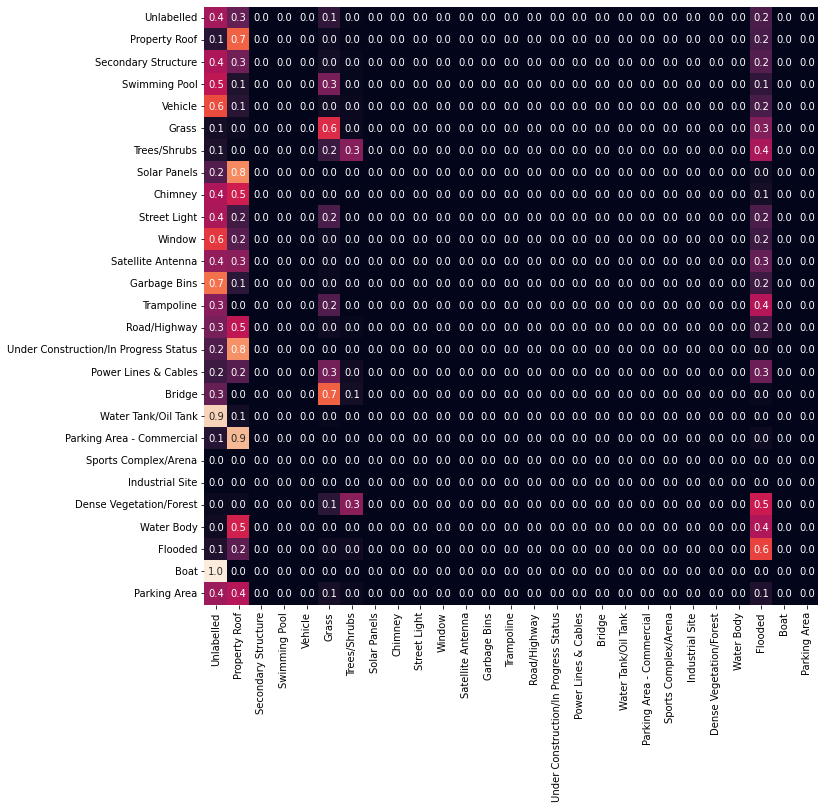

In [142]:

cm, masks, preds = compute_confusion_matrix(model, val_loader, final_siz, "true", device)

# real value is the row, predicted is the column


Much worse than before as it can be clearly seen

## Predictions ##

In [ ]:

def predict(model, test_df, test_dataset, device, dir_path):

  if not os.path.exists(dir_path):
    os.makedirs(dir_path)

  model.eval()
  model = model.to(device)
  with torch.no_grad():
    for idx in range(test_df.shape[0]):
      info = test_df.iloc[idx]
      name, path_img, size = info["name"], info["img"], info["size"]
      final_dim = (3000, 4000) if size==1 else (3072, 4592)   
      final_prediction = np.zeros(final_dim)

      img = test_dataset[idx]  
      img = img.view(-1, 3, test_dataset.final_size, test_dataset.final_size) 

      height_patch, width_patch = int(final_dim[0]/2), int(final_dim[1]/2)

      input = img.to(device)
      predictions_logits = model(input.float()).detach().cpu()
      predictions = torch.argmax(predictions_logits, dim=1).detach().numpy()  

      list_pred = []
      for idx in range(predictions.shape[0]): 

        resized_patch = cv2.resize(predictions[idx].astype(np.uint8), dsize=(width_patch, height_patch), interpolation=cv2.INTER_AREA)  
        list_pred.append(resized_patch.astype(np.uint8))

      final_prediction[:height_patch, :width_patch] = list_pred[0]
      final_prediction[:height_patch, width_patch:final_dim[1]] = list_pred[1]
      final_prediction[height_patch:final_dim[0], :width_patch] =  list_pred[2]
      final_prediction[height_patch:final_dim[0], width_patch:final_dim[1]] = list_pred[3]
      final_prediction = final_prediction.astype(np.uint8)


      im = Image.fromarray(final_prediction, "L")
      im.save(os.path.join(dir_path, f"{name}.png"), "PNG")
      

      

In [ ]:
model.eval()


pred_path = "drive/MyDrive/Hurricane_Harvey/Predictions_linknet"

if not os.path.exists(pred_path):
  os.makedirs(pred_path)

predict(model, test_df, test_dataset, device, dir_path=pred_path)

name_tar = "submission_linknet"

tar = tarfile.open(f"drive/MyDrive/Hurricane_Harvey/{name_tar}.tar", "w")

for root, dir, files in os.walk(pred_path):
    for file in files:
        fullpath = os.path.join(root, file)
        tar.add(fullpath, arcname=file)

tar.close()


In [144]:

def plot_mask_and_prediction(model, df, dataset):
  ''' again, had to be reimplemented for a difference in the API see above for the comments'''
  model = model.to(device)
  model.eval()
  with torch.no_grad():
    idx = np.random.randint(0, df.shape[0])
    try:
      img_name, img_path, mask_path, img_size = df.iloc[idx][["name", "img", "mask", "size"]]
    except:
      print("Insert either train or validation dataset")

    final_dim = (3000, 4000) if img_size==1 else (3072, 4592)

    real_mask = np.asarray(Image.open(mask_path))
    real_img = np.asarray(Image.open(img_path)) # not to pass through resize

    print(f"\nUnique labels in original: {np.unique(real_mask)}")

    img, mask = dataset[idx]  
    img = img.view(-1, 3, dataset.final_size[0], dataset.final_size[1])  # 4x3xdimxdim
    mask = mask.view(-1, dataset.final_size[0], dataset.final_size[1])   # 4xdimxdim
    input = img.to(device)
    predictions_logits = model.forward(input.float()).detach().cpu()
    predictions = torch.argmax(predictions_logits, dim=1).detach().squeeze().numpy().astype(np.uint8)  # 4xdimxdim

    final_prediction = cv2.resize(predictions, dsize=final_dim[::-1], interpolation=cv2.INTER_NEAREST)

    print(f"Unique labels in prediction: {np.unique(final_prediction)}\n")

    titles = ["Real img", "Real mask", "Predicted mask"]
    data = [real_img, real_mask, final_prediction]

    fig, axs = plt.subplots(1, 3, figsize=(22, 18))
    for idx, ax in enumerate(axs):
      ax.imshow(data[idx])
      ax.set_title(titles[idx], fontsize=18)
      ax.axis('off')    
    plt.show()



Unique labels in original: [ 0  5  6 14 16 22]
Unique labels in prediction: [ 0  1  5  6 24]



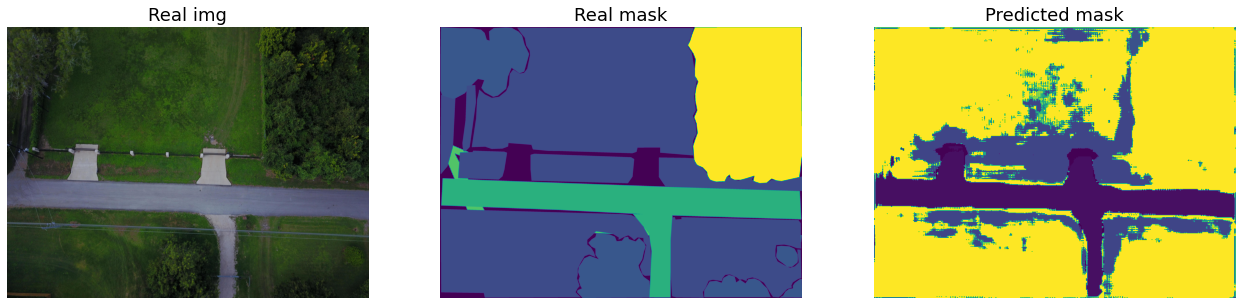

In [145]:

plot_mask_and_prediction(model, valid_df, valid_dataset)   # we do it on the validation dataset



Plotted to see interestingly the difference of a non-performing model

# PSPNet - ResNet101 encoder trained on ImageNet #

PSPNet used as a decoder with an hyper-parametrized encoder like ResNet proved to be the most competitive model among all. A powerful model that was already performing very well was helped by a change in the setup. We left the over-conceptualization exlained before and simply resize the full image to a given size (a rectangular $480$x$640$, to respect at least the proportion) without padding. Also, the engineered images were not used.

In [ ]:
model = smp.PSPNet('resnet101', 
             encoder_weights = 'imagenet', 
             psp_use_batchnorm=True,
             in_channels=3,
             classes=n_classes,
             upsampling=8, 
             activation = None)


## Dataframes ##

In [34]:
# Redefinition


img_names_clean = [os.path.splitext(filename)[0] for filename in sorted(os.listdir(IMG_FOLDER))]   
mask_names_clean = [os.path.splitext(filename)[0] for filename in sorted(os.listdir(MASK_FOLDER))]

trainable_names = list(set(mask_names_clean))  
test_names = sorted(list(set(img_names_clean).difference(set(trainable_names))))  

train_df, valid_df, test_df = gen_dataframes(trainable_names, test_names, prop_split=0.33)

train_names, valid_names = train_df["name"].tolist(), valid_df["name"].tolist()


print(f"Number of masks: {len(mask_names_clean)}")
print(f"Number of images: {len(img_names_clean)}")

print(f"\nCheck length of train set: {train_df.shape[0]}")
print(f"Check length of validation set: {valid_df.shape[0]}\n")
print(f"Check length of test set: {test_df.shape[0]}\n")

train_df.head()



Number of masks: 299
Number of images: 374

Check length of train set: 200
Check length of validation set: 99

Check length of test set: 75



initial  name                                                img  \
0       50  7467  /content/drive/MyDrive/Hurricane_Harvey/raster...   
1      240  6546  /content/drive/MyDrive/Hurricane_Harvey/raster...   
2       63  9925  /content/drive/MyDrive/Hurricane_Harvey/raster...   
3       94  6459  /content/drive/MyDrive/Hurricane_Harvey/raster...   
4      144  6420  /content/drive/MyDrive/Hurricane_Harvey/raster...   

                                                mask  size  
0  /content/drive/MyDrive/Hurricane_Harvey/vector...     0  
1  /content/drive/MyDrive/Hurricane_Harvey/vector...     1  
2  /content/drive/MyDrive/Hurricane_Harvey/vector...     1  
3  /content/drive/MyDrive/Hurricane_Harvey/vector...     1  
4  /content/drive/MyDrive/Hurricane_Harvey/vector...     1

## DataLoaders (simplified) ##

As explained above, we simplified the setting since the results from patching and resizing did not prove to be as expected.

In [35]:

class RasterDataset(Dataset):
  def __init__(self, data_df, stats, mask=True, transform=False, final_size=(450, 450)):
    
    ''' data_df: pandas dataframe with image and mask info
        stats: list [mean, std]
        transform: Albumination list of transforms (torch normalization by default)
        mask: bool, absence or presence of mask (test set vs others) 
        final_size: tuple of int, to specify final size of Resizing
        If a mask is passed, Albumination transforms are called on both images
        and mask and are expected to contain Normalization + Tensorization
        Otherwise, for the test set Normalization and Tensorization are autonoumously
        performed by the function and do not need to be provided through the list
        of transforms
        '''
    
    self.data = data_df
    self.transform = transform
    self.final_size = final_size
    self.stats=stats
    self.mask = mask

  def __len__(self):
    return self.data.shape[0]

  def __getitem__(self, index):
    info = self.data.iloc[index]
    full_img = cv2.imread(info["img"]) 
    full_img = cv2.cvtColor(full_img, cv2.COLOR_BGR2RGB)

    if self.mask:
      full_mask = cv2.imread(info["mask"], cv2.IMREAD_GRAYSCALE).astype(np.float32)
    
    if (self.mask) and (self.transform):
      # Albumination (used instead of torch to pass mask together with images), no transform for test set (need normalization and tensorization at the end by default)
      transformed = self.transform(image=full_img, mask=full_mask)
      full_img = transformed["image"].float()
      full_mask = transformed["mask"].long()
      return full_img, full_mask
    else:
      transf = T.Compose([T.Resize((self.final_size[0], self.final_size[1])), T.ToTensor(), T.Normalize(*self.stats)])
      full_img = transf(Image.fromarray(full_img))[None, :, :, :]
      return full_img




In [20]:

# only transformations (on squared patches) to be defined are the distortion ones, resizing is taken care of by the function itself

final_siz = (480, 640)

train_transform = A.Compose(
                              [   
                                  A.Resize(final_siz[0], final_siz[1], interpolation=cv2.INTER_AREA),
                                  A.RandomBrightnessContrast(brightness_limit=0.25, contrast_limit=0.25, p=0.4),
                                  A.HueSaturationValue(20, 20, 20, p=0.4),
                                  A.Normalize(*stats),
                                  ToTensorV2(),
                              ]
                            )

valid_transform = A.Compose(
                              [  
                                  A.Normalize(*stats),
                                  ToTensorV2(),
                              ]
                            )


train_dataset = RasterDataset(train_df, stats=stats, transform=train_transform, final_size=final_siz) 


valid_dataset = RasterDataset(valid_df, stats=stats, transform=valid_transform, final_size=final_siz)  
test_dataset = RasterDataset(test_df, stats=stats, final_size=final_siz, mask=False)


batch_loader = 4

train_loader = DataLoader(train_dataset, batch_size=batch_loader, shuffle=True, pin_memory=True) 
val_loader = DataLoader(valid_dataset, batch_size=batch_loader, shuffle=False, pin_memory=True) 


## Model ##

In [170]:
n_classes = len(label_dict)  


model = smp.PSPNet('resnet101', 
             encoder_weights = 'imagenet', 
             psp_use_batchnorm=True,
             in_channels=3,
             classes=n_classes,
             upsampling=8, 
             activation = None)

model



Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

PSPNet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
    

## Optimizers and hyperparameters ##

Much smaller learning rates (around $1/10$) implemented, lowered less abruptly by the learning rate scheduler. The patience of the EarlyStopping was slightly raised to allow the model to run (while saving the checkpoints).

In [172]:
# optimizer


model = model.to(device)

lr_ = 0.0005
weight_dec = 1e-4


optimizer = torch.optim.Adam(model.parameters(), lr=lr_, weight_decay=weight_dec)

patience = 5
schedul_params = {"mode": 'min', "factor": 0.5, "patience": patience, "threshold": 1e-4}
sched = lr_scheduler.ReduceLROnPlateau(optimizer, **schedul_params)



In [173]:


device = "cuda" if torch.cuda.is_available() else "cpu"

criterion = nn.CrossEntropyLoss() 


## Wandb logging ##

In [175]:
# Wandb connection passing all parameters and device

wandb_connect()
wandb_project_name = "Kaggle_competition"


name_run = "psp_final"   # !!!!!! change name
name_model = "model_" + name_run

epochs = 50   # Early Stopping implemented

net = {"epochs": epochs,
        "opt": type(optimizer),
        "learning rate" : lr_,
        "momentum": moment,
        "weight decay": weight_dec,
        "scheduler": type(sched), 
        "scheduler_param": schedul_params,
        "mode": type(model),
        "criterion": type(criterion)
       }  


run = wandb.init(project=wandb_project_name, reinit=True, name=f"{name_run}", config=net) 


# create directory to save model's parameters
root = "/content/drive/MyDrive/Hurricane_Harvey/Model_parameters"

tot_path = os.path.join(root, str(name_model))


# Early Stopping

early_stopping = EarlyStopping(patience=8, verbose=False, delta=0, path=tot_path, save_every=5)  # Early Stopping




wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Connected to Wandb online interface : True


## Training loop ##

In [195]:

def train_model(model, epochs, train_loader, val_loader, optimizer, criterion, sched, early_stopping, device, size):
  ''' redefined only for a size change, apologies (lack of time) '''

  history = defaultdict(list)
  model = model.to(device)

  for epoch in tqdm(range(1, epochs+1)): 
    # Stores and Metrics
    train_store = []
    wandb.log({"epochs": epoch})

    dice_score_tr = torch.zeros((1)).to(device)
    mean_iou_tr = torch.zeros((1)).to(device)

     ## TRAINING
    model.train()
    for idx, (im, mask) in enumerate(train_loader):
      torch.cuda.empty_cache()
      im_batch = im.view(-1, 3, size[0], size[1]).to(device)                           
      mask_batch = mask.view(-1, size[0], size[1]).long().to(device)

      optimizer.zero_grad()
      output = model(im_batch.float()).to(device)

      loss = criterion(output, mask_batch)
      loss.backward()
      optimizer.step()
      train_store.append(loss.item())

      predictions = torch.argmax(F.softmax(output.detach(), dim=1), dim=1).to(device)
      dice_score_tr += dice_coefficient(predictions, mask_batch, device)
      mean_iou_tr += mean_iou(predictions, mask_batch, device)
      
      wandb.log({"train_loss_batch": loss.item()}) 

      # Scheduler based on batches
      if isinstance(sched, lr_scheduler.OneCycleLR):
        history["learning_rates"].append(optimizer.param_groups[0]["lr"])
        sched.step()

    train_loss_mean = np.mean(train_store)
    mean_iou_tr = mean_iou_tr/len(train_loader)
    dice_score_tr = dice_score_tr/len(train_loader)
    history = update_history(history, train_loss_mean, 
                              mean_iou_tr.item(), dice_score_tr.item(), type_="tr")

    wandb.log({"train_loss": train_loss_mean, "mean_iou_tr": mean_iou_tr, "dice_score_train": dice_score_tr})

    ## VALIDATION
    model.eval() 

    val_store = []
    dice_score_val = torch.zeros((1)).to(device)
    mean_iou_val = torch.zeros((1)).to(device)

    with torch.no_grad():
      for idx, (im, mask) in enumerate(val_loader):
        torch.cuda.empty_cache()
        im_batch = im.view(-1, 3, h, w).to(device)                 
        mask_batch = mask.view(-1, h, w).long().to(device)   
      
        output = model(im_batch.float()).to(device) 
        
        loss = criterion(output, mask_batch)
        val_store.append(loss.item())

        predictions = torch.argmax(F.softmax(output.detach(), dim=1), dim=1).to(device)
        dice_score_val += dice_coefficient(predictions, mask_batch, device)
        mean_iou_val += mean_iou(predictions, mask_batch, device)

    val_loss_mean = np.mean(val_store)
    mean_iou_val = mean_iou_val/len(val_loader)  # vector
    dice_score_val = dice_score_val/len(val_loader)
    history = update_history(history, val_loss_mean, 
                           mean_iou_val.item(), dice_score_val.item(), type_="val")
  
    # Scheduler based on epochs
    if isinstance(sched, lr_scheduler.ReduceLROnPlateau):
      history["learning_rates"].append(optimizer.param_groups[0]["lr"])
      sched.step(val_loss_mean)
  
    # Log to Wandb
    wandb.log({"valid_loss": val_loss_mean, "mean_iou_val": mean_iou_val, "dice_score_valid": dice_score_val, "learning_rate": optimizer.param_groups[0]["lr"]})

    print(
            "Epoch [{}/{}]..".format(epoch, epochs),
            "Train loss: {:.4f}..".format(train_loss_mean),
            "Validation loss: {:.4f}..".format(val_loss_mean),
            "Mean_iou train: {:.4f}..".format(mean_iou_tr.item()),
            "Mean_iou valid: {:.4f}..".format(mean_iou_val.item()),
            "Dice_score train: {:.4f}..".format(dice_score_tr.item()),
            "Dice_score valid: {:.4f}..".format(dice_score_val.item())
          )

    # early_stopping needs the validation loss to check if it has decresed, 
    # and if it has, it will make a checkpoint of the current model
    early_stopping(val_loss_mean, model, epoch)

    if early_stopping.early_stop:
        print("Early stopping")
        break

  return history



In [197]:


history = train_model(model, epochs, train_loader, val_loader, optimizer, criterion, sched, early_stopping, device, final_siz)

# close wandb session
run.finish()


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50].. Train loss: 1.6312.. Validation loss: 1.5536.. Mean_iou train: 0.0798.. Mean_iou valid: 0.0875.. Dice_score train: 0.1732.. Dice_score valid: 0.1837..
Epoch [2/50].. Train loss: 1.3261.. Validation loss: 1.4606.. Mean_iou train: 0.1059.. Mean_iou valid: 0.1058.. Dice_score train: 0.2206.. Dice_score valid: 0.2184..
Epoch [3/50].. Train loss: 1.1667.. Validation loss: 1.3590.. Mean_iou train: 0.1236.. Mean_iou valid: 0.1205.. Dice_score train: 0.2502.. Dice_score valid: 0.2433..
Epoch [4/50].. Train loss: 1.1192.. Validation loss: 1.6419.. Mean_iou train: 0.1310.. Mean_iou valid: 0.1048.. Dice_score train: 0.2632.. Dice_score valid: 0.2300..

EarlyStopping counter: 1 out of 8

Epoch [5/50].. Train loss: 1.1036.. Validation loss: 1.5158.. Mean_iou train: 0.1332.. Mean_iou valid: 0.1104.. Dice_score train: 0.2701.. Dice_score valid: 0.2258..

EarlyStopping counter: 2 out of 8

Epoch [6/50].. Train loss: 1.0470.. Validation loss: 1.2555.. Mean_iou train: 0.1405.. Mean_iou va

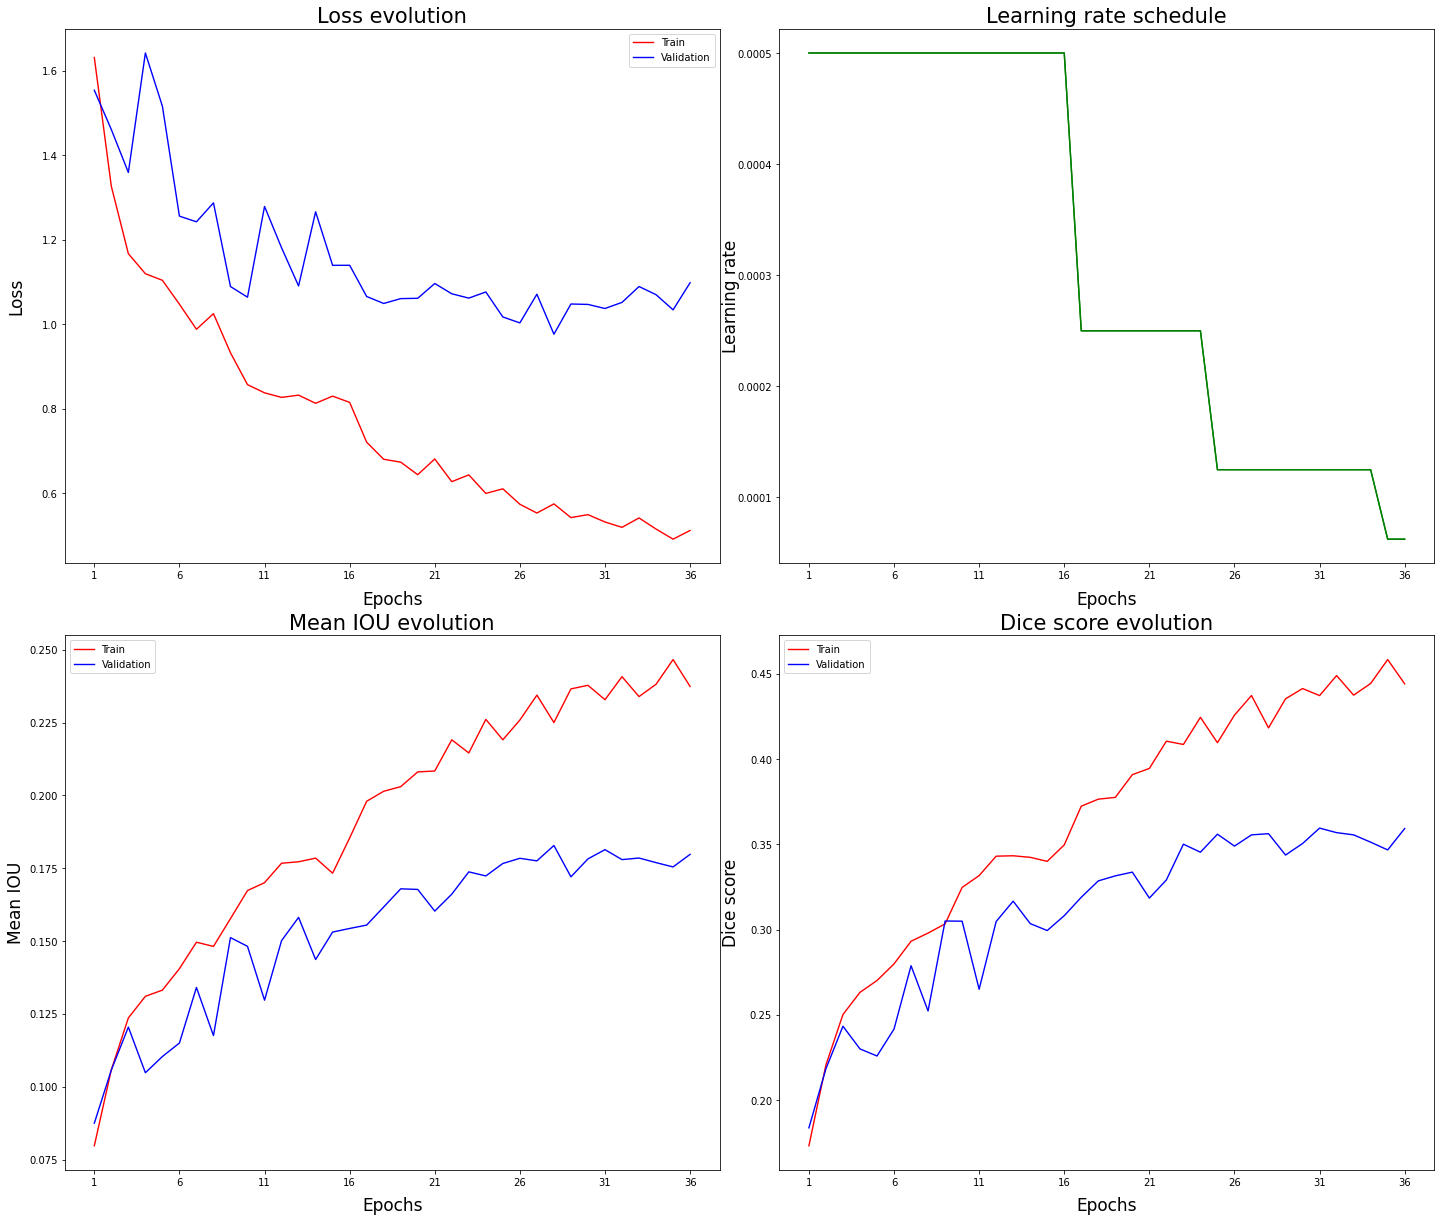

In [203]:
name = "PSPNet-final"

graph_single(history, name)



We can see from the graphs that the EarlyStopping mechanism worked nicely, since the iterations are stopped at the right moment (when the validation loss is starting to increase). The best performance model was indeed coming from the checkpoint corresponding to an iterations around the $30$th, and it provided a $74\%$ score in the competition

## Reload model ##

In [21]:
n_classes = len(label_dict)  # 27 (also unlabelled)


model = smp.PSPNet('resnet101', 
             encoder_weights = 'imagenet', 
             psp_use_batchnorm=True,
             in_channels=3,
             classes=n_classes,
             upsampling=8, 
             activation = None)

# Re-load model

root = "drive/MyDrive/Hurricane_Harvey"

timestamp_path = 'Model_parameters/model_psp_final_e28.pt'  #10, 15, 18, 28, 30, 35

model.load_state_dict(torch.load(os.path.join(root, timestamp_path)))  #map_location=torch.device("cpu")


Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

<All keys matched successfully>

## Confusion Matrix  ##

/usr/local/lib/python3.8/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: 54 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


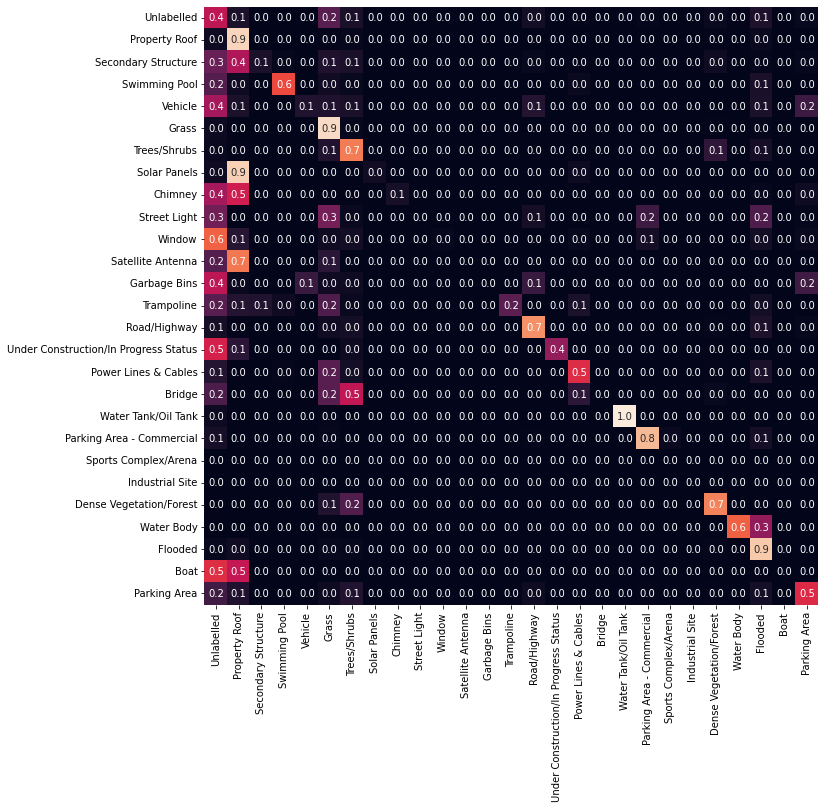

In [29]:

cm, masks, preds = compute_confusion_matrix(model, val_loader, final_siz, "true", device)

# real value is the row, predicted is the column


This is the best performing model, and it can be seen from the displayed confusion matrix. Also the unlabelled pixels and much more often correctly guessed


Unique labels in original: [ 0  1  2  3  4  5  6  7  8  9 10 16 22 24 26]
Unique labels in prediction: [ 0  1  3  5  6 16 24 26]



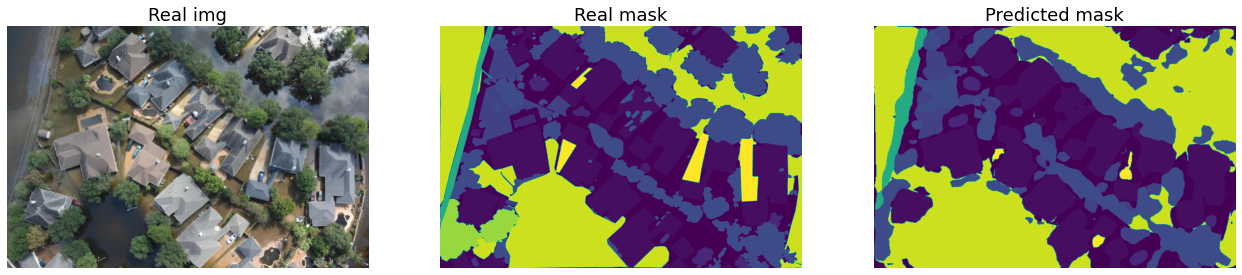

In [78]:
plot_mask_and_prediction(model, valid_df, valid_dataset)

In [150]:

def predict(model, test_df, test_dataset, device, dir_path):

  if not os.path.exists(dir_path):
    os.makedirs(dir_path)

  model.eval()
  model = model.to(device)
  with torch.no_grad():
    for idx in range(test_df.shape[0]):
      info = test_df.iloc[idx]
      name, path_img, size = info["name"], info["img"], info["size"]
      final_dim = (3000, 4000) if size==1 else (3072, 4592)   #0 if Image.open(path_image(name)).size[0]==4592 else 1) 

      img = test_dataset[idx]  # they are the same if no transformations, img is 1x4x3xdimxdim, mask
      img = img.view(-1, 3, test_dataset.final_size[0], test_dataset.final_size[1])  # 4x3xdimxdim

      input = img.to(device)
      predictions_logits = model(input.float()).detach().cpu()
      predictions = torch.argmax(predictions_logits, dim=1).squeeze().numpy().astype(np.uint8)  # 4xdimxdim

      final_prediction = cv2.resize(predictions, dsize=final_dim[::-1], interpolation=cv2.INTER_LINEAR)

      im = Image.fromarray(final_prediction, "L")
      im.save(os.path.join(dir_path, f"{name}.png"), "PNG")
      

In [146]:
n_classes = len(label_dict)  


model = smp.PSPNet('resnet101', 
             encoder_weights = 'imagenet', 
             psp_use_batchnorm=True,
             in_channels=3,
             classes=n_classes,
             upsampling=8, 
             activation = None)

# Re-load model

root = "drive/MyDrive/Hurricane_Harvey"

timestamp_path = 'Model_parameters/model_psp_final_e35.pt'  #10, 15, 18, 28, 30, 35

model.load_state_dict(torch.load(os.path.join(root, timestamp_path)))  


<All keys matched successfully>

In [148]:
model.eval()

pred_path = "drive/MyDrive/Hurricane_Harvey/Predictions_pspnet_final4"

if not os.path.exists(pred_path):
  os.makedirs(pred_path)



In [151]:

predict(model, test_df, test_dataset, device, dir_path=pred_path)



In [152]:


name_tar = "submission_pspnet_final"

tar = tarfile.open(f"drive/MyDrive/Hurricane_Harvey/{name_tar}.tar", "w")

for root, dir, files in os.walk(pred_path):
    for file in files:
        fullpath = os.path.join(root, file)
        tar.add(fullpath, arcname=file)

tar.close()


# Unet, with ResNet34 encoder trained on Imagenet #

This was one of the first models tried, with a setup based on the resizing of entire images (similar to PSPNet). A Unet decoder was used, with pretrained weights coming from a library called "segmentation models pytorch". The Decoder channels, representing the dimensions of channels used during the oversampling of the feature embedding, are made deeper than what described in the original formulation. Also, an additional head of fully connected layer is called through the API, which allows to insert Dropout

In [ ]:
n_classes = len(label_dict)  # 27 (also unlabelled)


aux_param = {"classes": n_classes, "dropout": 0.2, "activation": None}

# https://segmentation-modelspytorch.readthedocs.io/en/latest/

model = smp.Unet('resnet34', encoder_depth=5,
                 encoder_weights = 'imagenet', 
                 decoder_use_batchnorm=True,
                 decoder_channels=[768, 512, 254, 128, 64],
                 decoder_attention_type=None,
                 in_channels=3,
                 classes=n_classes, 
                 activation = None)  # activation None since Torch CrossEntropy does softmax on its own



Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:

model


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

## Hyperparameters ##

Here we use a large initial learning rate, with a tight learning rate scheduler that could allow to reduce it progressively.

### Learning rate, momentum and optimizer ###



In [ ]:


model = model.to(device)

lr_ = 0.01
weight_dec = 1e-4
moment = 0.85


optimizer = torch.optim.Adam([{"params": model.encoder.parameters(), "lr": 0.05*lr_},
                                 {"params": model.decoder.parameters()}], lr=lr_, weight_decay=weight_dec)


schedul_params = {"mode": 'min', "factor": 0.5, "patience": 3, "threshold": 1e-4}
sched = lr_scheduler.ReduceLROnPlateau(optimizer, **schedul_params)



### Loss function ###

In [ ]:

device = "cuda" if torch.cuda.is_available() else "cpu"


weights = torch.tensor([1/n_classes]*n_classes).to(device)    # Tensor of size C

criterion = nn.CrossEntropyLoss(weight=weights)




### Wandb logging ###

In [ ]:
# Wandb connection passing all parameters and device

wandb_connect()
wandb_project_name = "Kaggle_competition"


name_run = "prova_entire"   # !!!!!! change name
name_model = "model_" + name_run

epochs = 60   # Early Stopping implemented

net = {"epochs": epochs,
        "opt": type(optimizer),
        "learning rate" : lr_,
        "momentum": moment,
        "weight decay": weight_dec,
        "scheduler": type(sched), 
        "scheduler_param": schedul_params,
        "mode": model.name,
        "criterion": type(criterion),
        "batch_size": batch_loader,
        "patching": patch_,
        "n_patches_considered": batch_patches,
        "size_patches_considered": size_patches,
        "pad_big": train_dataset.pad_big, 
        "pad_small": train_dataset.pad_small
       }  

run = wandb.init(project=wandb_project_name, reinit=True, name=f"{name_run}", config=net) 


# create directory to save model's parameters

root = "/content/drive/MyDrive/Hurricane_Harvey/Model_parameters"


tot_path = os.path.join(root, str(name_model))
early_stopping = EarlyStopping(patience=12, verbose=False, delta=0, path=tot_path, save_every=5)  # Early Stopping




wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Connected to Wandb online interface : True


mkdir: cannot create directory ‘/content/drive/MyDrive/Hurricane_Harvey/Model_parameters’: File exists


### Sanity Checks ###

Shapes and types torch.Size([4, 3, 288, 352]) torch.Size([4, 1, 288, 352]) <class 'torch.Tensor'> <class 'torch.Tensor'>


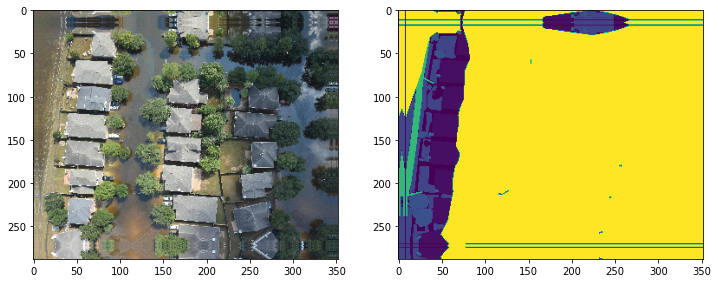

In [ ]:

check_image_mask(train_loader, denormalize, final_siz)



## Training Loop ##

In [ ]:


history = train_model(model, epochs, train_loader, val_loader, optimizer, criterion, sched, device)



  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [1/60].. Train loss: 2.1572.. Validation loss: 1.9673.. Pixel_acc train: 0.2754.. Pixel_acc valid: 0.3253..
Epoch [2/60].. Train loss: 2.0272.. Validation loss: 1.9274.. Pixel_acc train: 0.3223.. Pixel_acc valid: 0.3368..
Epoch [3/60].. Train loss: 1.9510.. Validation loss: 1.9472.. Pixel_acc train: 0.3405.. Pixel_acc valid: 0.3230..

EarlyStopping counter: 1 out of 12

Epoch [4/60].. Train loss: 1.9067.. Validation loss: 1.8200.. Pixel_acc train: 0.3556.. Pixel_acc valid: 0.3582..
Epoch [5/60].. Train loss: 1.8714.. Validation loss: 1.7672.. Pixel_acc train: 0.3505.. Pixel_acc valid: 0.3669..
Epoch [6/60].. Train loss: 1.8225.. Validation loss: 1.7606.. Pixel_acc train: 0.3686.. Pixel_acc valid: 0.3976..
Epoch [7/60].. Train loss: 1.8039.. Validation loss: 1.8194.. Pixel_acc train: 0.3657.. Pixel_acc valid: 0.3617..

EarlyStopping counter: 1 out of 12

Epoch [8/60].. Train loss: 1.7838.. Validation loss: 1.6937.. Pixel_acc train: 0.3821.. Pixel_acc valid: 0.4180..
Epoch [9/60]..

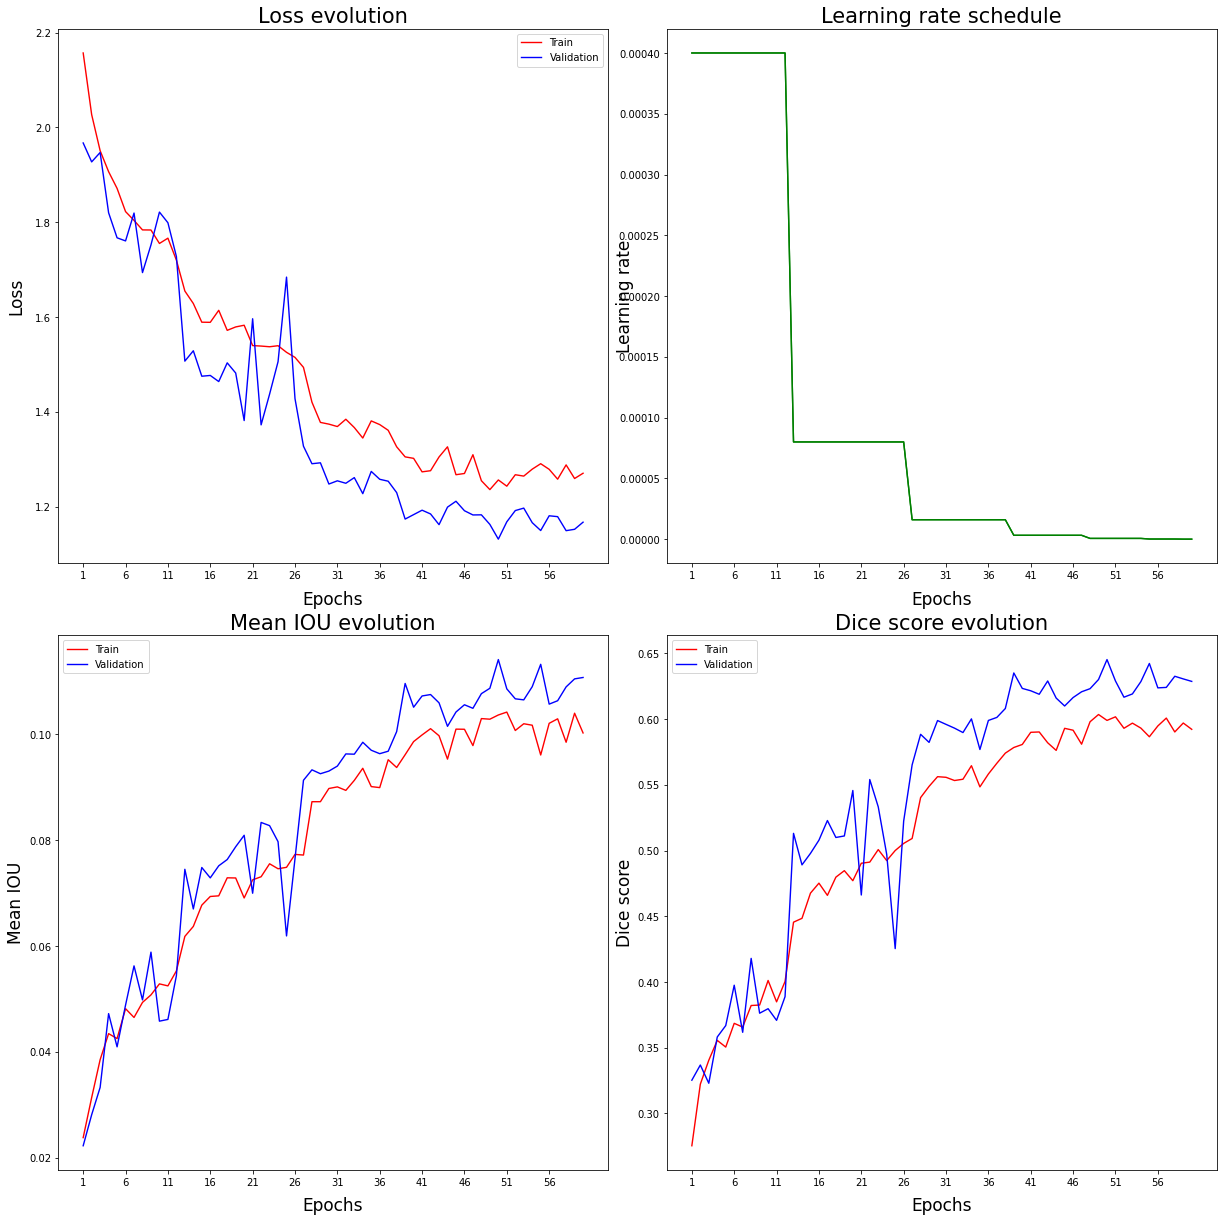

In [ ]:

graph_single(history, epochs, "Unet-full(288x352)-CEntropy-RProp(2 lr)")



### Confusion Matrix ###

In [ ]:
# Load the same model as the chosen one (same architecture, to instantiate it )

root = "drive/MyDrive/Hurricane_Harvey"

model = smp.Unet('resnet34', encoder_depth=5,
                 encoder_weights = 'imagenet', 
                 decoder_use_batchnorm=True,
                 decoder_channels=[768, 512, 254, 128, 64],
                 decoder_attention_type=None,
                 in_channels=3,
                 classes=n_classes, 
                 activation = None).to(device)

timestamp_path = 'Model_parametersmodel_prova_entire_e50.pt'

model.load_state_dict(torch.load(os.path.join(root, timestamp_path)))  #map_location=torch.device("cpu")



<All keys matched successfully>

/usr/local/lib/python3.8/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: 27 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


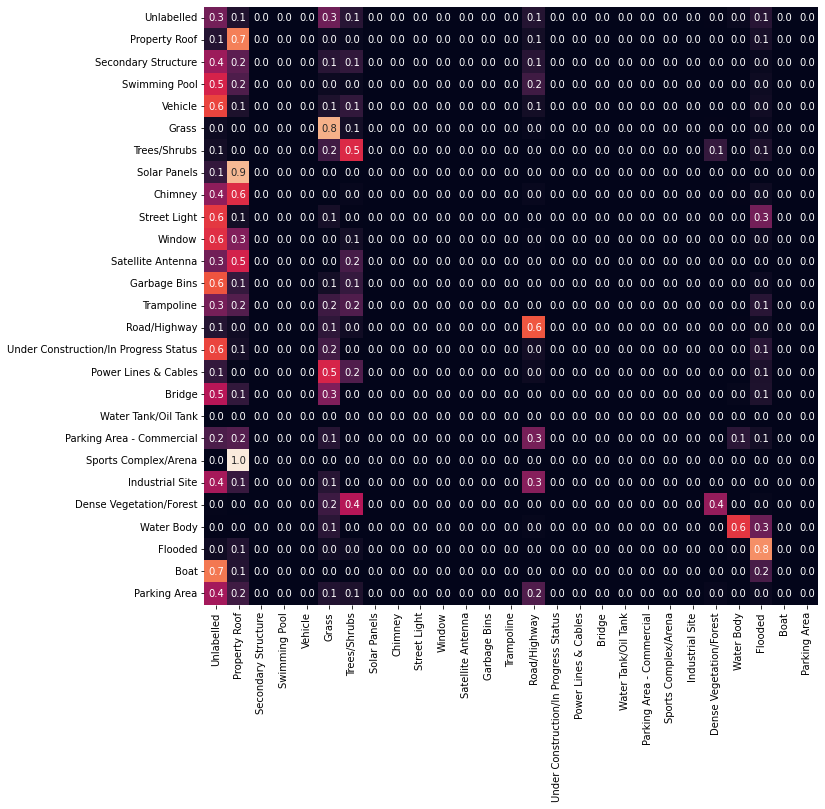

In [ ]:



cm, masks, preds = compute_confusion_matrix(model, val_loader, patch_, normal="true", device=device)

# real value is the row, predicted is the column


It can be seen the difference with PSPNet ($15\%$ difference for the Kaggle score, from $62$ to $74$

In [ ]:
import tarfile

tar = tarfile.open("drive/MyDrive/Hurricane_Harvey/submission.tar", "w")


for root, dir, files in os.walk(pred_path):
    for file in files:
        fullpath = os.path.join(root, file)
        tar.add(fullpath, arcname=file)

tar.close()


### Work with Images ###

(3072, 4592, 3)


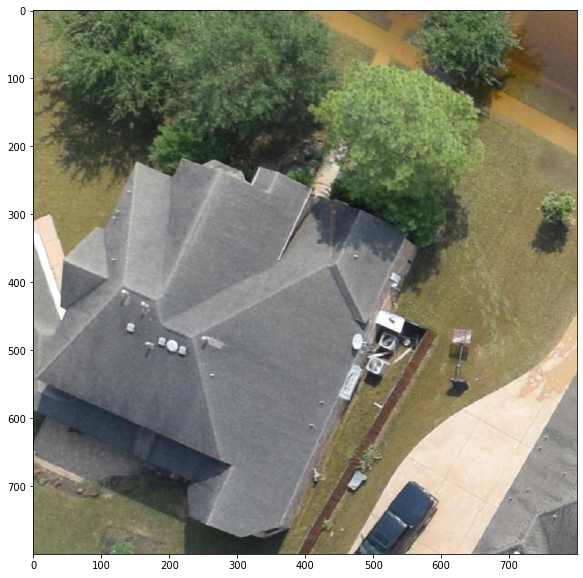

In [ ]:

a = np.asarray(Image.open(os.path.join(IMG_FOLDER, list(train_names)[0] + ".tif")))
print(a.shape)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(a[1000:1800, 1000:1800, :])




Number of vertices: 6



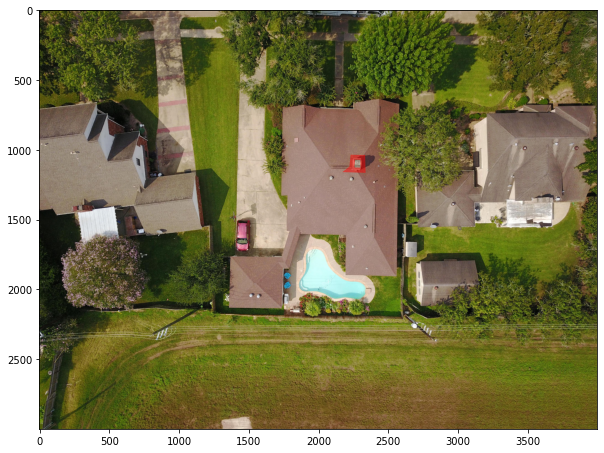

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

im = np.asarray(Image.open(os.path.join(IMG_FOLDER, "10170" + ".tif")))
mask = np.asarray(Image.open(os.path.join(MASK_FOLDER, "10170" + ".png")))

lab = 0

ax.imshow(im)

coord = [2221.0,
         1143.0,
         2319.0,
         1146.0,
         2317.0,
         1054.0,
         2246.0,
         1053.0,
         2239.0,
         1129.0,
         2221.0,
         1143.0]

coord = np.array(coord).reshape(-2, 2)
print(f"\nNumber of vertices: {coord.shape[0]}\n")
tri = Polygon(coord, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
ax.add_patch(tri)


plt.show() 